### Imports

In [1]:
import pandas as pd
import math
import numpy as np
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import matplotlib
from matplotlib import pyplot
yf.pdr_override()


import cvxpy as cp
import itertools
from itertools import permutations 
from math import sqrt, exp
import scipy.integrate as si
import scipy.optimize as so
import scipy.stats as ss
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model

### Constants

In [23]:
coke_start = '2000-01-01'
coke_end = '2023-11-30'
# coke_end ='2018-12-31'

pepsi_start = '2000-01-01'
pepsi_end = '2023-11-30'
# pepsi_end ='2018-12-31'

coke_tkr='COKE'
pepsi_tkr='PEP'

np.random.seed(seed=49)

### Load Data

In [24]:
df_c= pdr.get_data_yahoo(coke_tkr, start=coke_start, end=coke_end)
df_p= pdr.get_data_yahoo(pepsi_tkr, start=pepsi_start, end=pepsi_end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Data Pre-Processing

<Axes: xlabel='Date'>

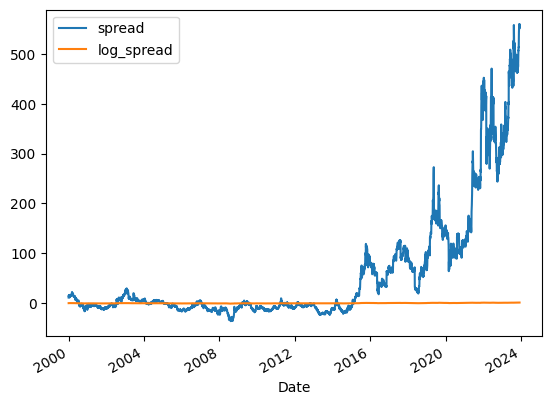

In [25]:
# Percent Returns
df_c['pct_rets'] = (df_c['Close']-df_c['Close'].shift(1))/df_c['Close'].shift(1)
df_p['pct_rets'] = (df_p['Close']-df_p['Close'].shift(1))/df_p['Close'].shift(1)

# Calculate log Prices
df_c['log_Close'] = np.log(df_c['Close'])
df_p['log_Close'] = np.log(df_p['Close'])

# Calculate Log Returns
df_c['log_rets']=df_c['log_Close']-df_c['log_Close'].shift(1)
df_p['log_rets']=df_p['log_Close']-df_p['log_Close'].shift(1)

# Calculate the Spread
df_d=df_c.merge(df_p, left_index=True, right_index=True, suffixes=('_C','_P'))
df_d['spread']=df_d['Close_C']-df_d['Close_P']
df_d['log_spread']=df_d['log_Close_C']-df_d['log_Close_P']

# Plot the spreads
df_d[['spread','log_spread']].plot()

In [89]:
# df_d.to_csv('final_project_data.csv')

### Co-Integration Test

#### Unit Root Tests

In [5]:
# Co-Integration occurs between two non-stationary series

# Perform unit root test (stationarity test)
unit_root_C = adfuller(df_d['Close_C'])
print('Coke unit-root p-value:', unit_root_C[1])

unit_root_P = adfuller(df_d['Close_P'])
print('Pepsi unit-root p-value:', unit_root_C[1])

print('Fail to reject null hypothesis. ' + \
      'p-values are > 0.05 for both so both time series have a unit root.')


Coke unit-root p-value: 0.9024050367818434
Pepsi unit-root p-value: 0.9024050367818434
Fail to reject null hypothesis. p-values are > 0.05 for both so both time series have a unit root.


### Engle-Granger Cointegration Test

The Engle-Granger Cointegration test considers the case when there is a single cointigrating vector. The procedure for the test asserts that two variables are cointegrated, then the residual of the cointegration is stationary.

Since the cointegration vector is not known, we can use Ordinary Least Squares Estimator to derive it.

According to OLS: <br>
-    True LR: y1t = c + B y2t + ut    (where ut is the error component) <br>
-    Predicted LR: y1t* = c* + B* y2t <br>
-    Predicted error component: ut*= y1t - y1t* <br>

-    Therefore: ut*=y1t - c* - B*y2t

From OLS: <br>
-    c* = y1t(mean) - B* y2t(mean) <br>
-    B* = SUM((y1t-y1t(mean))(y2t-y2t(mean))) / SUM((y2t-y2t(mean))^2) <br>


For Reference:
https://www.aptech.com/blog/a-guide-to-conducting-cointegration-tests/

In [6]:
# Estime Coefficients from OLS
B_hat = sum((df_d['Close_C'] - df_d['Close_C'].mean())*(df_d['Close_P']-df_d['Close_P'].mean())) /  +\
      sum(((df_d['Close_P']-df_d['Close_P'].mean()))**2)
c_hat = df_d['Close_C'].mean() - (B_hat* (df_d['Close_P'].mean()))


# Plot the Cointegration Error
u_hat = df_d['Close_C'] - c_hat - (B_hat*df_d['Close_P'])
# u_hat.plot()


# Conduct AD-Fuller Test on Cointegration Error to determine if Coke & Pepsi are cointegrated
u_hat_unit_root = adfuller(u_hat)
print('Cointegration unit-root p-value:', u_hat_unit_root[1])
print('Fail to accept null hypothesis. ' + \
      'p-value is <= 0.05 so timeseries is stationary. \n'  + \
      'Coke and Pepsi are Co-Integrated')

Cointegration unit-root p-value: 0.03702238575275194
Fail to accept null hypothesis. p-value is <= 0.05 so timeseries is stationary. 
Coke and Pepsi are Co-Integrated


### Preprocessing of Data

Spread Returns

In [7]:
# Drop na's
df_d.dropna(inplace=True)

# Spread Returns 
df_d['spread_simple_returns']=df_d['pct_rets_C']-df_d['pct_rets_P']
df_d['spread_log_returns']=df_d['log_rets_P']-df_d['log_rets_P']

# Plot spread returns
# df_d[['spread','spread_returns']].plot()

Train and Test Sets

In [26]:
# Create train and test sets 

# 80% train and 20% test
df_d.sort_index
df_train=df_d[:int(len(df_d)*0.8)].copy()
df_test=df_d[int(len(df_d)*0.8):].copy()

print(f'Train set date range: {df_train.index[0]} ---- {df_train.index[-1]}')
print(f'Test set date range: {df_test.index[0]} ---- {df_test.index[-1]}')

Train set date range: 2000-01-03 00:00:00 ---- 2019-02-19 00:00:00
Test set date range: 2019-02-20 00:00:00 ---- 2023-11-29 00:00:00


Normalize Spreads

In [27]:
# Normalize Training Spread
# df_d['spread_norm']=(df_d['spread']-df_d['spread'].mean())/df_d['spread'].std()
df_train['spread_norm']=ss.zscore(df_train['spread'])

# Normalize Testing Spread
df_test['spread_norm']=ss.zscore(df_test['spread'])

### Naive Optimization of Stopping Points

In [199]:
# Function for returning the latest datetime
# in the interval when S crossed over the aS/aL threshold

def consecutive_intervals(a):
    '''
    Parameters
    a = interval array for all indices where S >= aS or S <= aL

    Returns
    list of indices for when S first crosses a consecutive threshold
    '''

    # Difference interval array to find consecutive and discontinous intervals
    differences=np.array([j-i for i,j in zip(a[:-1], a[1:])])

    # Find where the intervals are discontinuous
    not_one=np.where(differences != 1)[0]

    # For every continuous interval, find starting position
    start_of_intervals=[]
    for x,(i) in enumerate(not_one):

        if x ==0:
            try: # error handling in case first array value is 0
                start_of_intervals.append(a[:i][0])
            except:
                start_of_intervals.append(0)
                
            start_of_intervals.append(a[i+1])
        else:
            start_of_intervals.append(a[i+1])

    return start_of_intervals

Best Total Log Returns: 0.9682031474807431
Best Threshold Pair: (1.5686350120353143, -1.625483467407281)


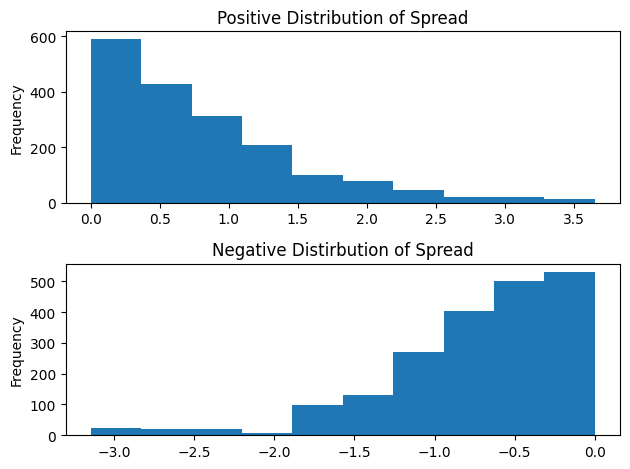

In [200]:
# Spread statistics
# print('Spread Statistics \n', df_train['spread'].describe())

# Normalized Spread Statistics
# print('Normalized Spread Statistics \n', df_train['spread_norm'].describe())



# Get the quantiles for the positive & negative distributions of spread
fig, ax = plt.subplots(nrows=2, ncols=1)

# Positive quantiles for aS
df_train.loc[df_train['spread_norm']>0]['spread_norm'].plot(kind='hist', ax=ax[0], title='Positive Distribution of Spread')
pos_q_95=df_train.loc[df_train['spread_norm']>0]['spread_norm'].quantile(q=0.95)
pos_q_90=df_train.loc[df_train['spread_norm']>0]['spread_norm'].quantile(q=0.9)
pos_q_85=df_train.loc[df_train['spread_norm']>0]['spread_norm'].quantile(q=0.85)
# print('The 90th quantile for the positive distribution of spread is:', pos_q_90)

# Positive quantiles for aL
df_train.loc[df_train['spread_norm']<0]['spread_norm'].plot(kind='hist', ax=ax[1], title='Negative Distirbution of Spread')
neg_q_05=df_train.loc[df_train['spread_norm']<0]['spread_norm'].quantile(q=0.05)
neg_q_10=df_train.loc[df_train['spread_norm']<0]['spread_norm'].quantile(q=0.1)
neg_q_15=df_train.loc[df_train['spread_norm']<0]['spread_norm'].quantile(q=0.15)
# print('The 10th quantile for the negative distirbution of spread is', neg_q_10)

fig.tight_layout()


# Solve the in-sample optimization problem by trial and error 
# Get aS and aL pairs in the neighbourhood of the 90th/10th quantiles
aS_neighbourhood=np.linspace(start= pos_q_95, stop=pos_q_85, num=40)
aL_neighbourhood=np.linspace(start= neg_q_05, stop=neg_q_15, num=40)

# Create param_grid space
# Every combination of aS with aL
threshold_pairs=[]
for i in range(len(aS_neighbourhood)):
    for j in range(len(aL_neighbourhood)):
        threshold_pairs.append((aS_neighbourhood[i], aL_neighbourhood[j]))


# Optimize aS and aL thresholds
best_returns=-100
best_pair=0
best_stance=np.zeros(len(df_train))
for i, pair in enumerate(threshold_pairs): 

    # Calculate Stance
    
    # Initialize with zero
    df_train['stance']=0


    # Create stances
    
    # normalized spread
    s = df_train['spread_norm'].values

    # Positive cross over points
    pos_cross_overs = [x for x,(j,i) in enumerate(zip(s[1:],s[:-1])) if (np.sign(j) > np.sign(i))]
    # Negative cross over points
    neg_cross_overs = [x for x,(j,i) in enumerate(zip(s[1:],s[:-1])) if (np.sign(j) < np.sign(i))]

    # aS cross over points
    aS_intervals = np.where(s >= pair[0])[0]
    aS_start_intervals = consecutive_intervals(aS_intervals)

    # aL cross over points
    aL_intervals = np.where(s <= pair[1])[0]
    aL_start_intervals = consecutive_intervals(aL_intervals)


    # Create Short Stances
    aS_windows=[]
    s=0
    # Check for mean reversion between each pos aS cross over point
    for w in range(1,len(aS_start_intervals)):
        # Check window for root
        r = [c for c in pos_cross_overs if (c>aS_start_intervals[s]) & (c<aS_start_intervals[w])]
        if len(r)>=1:
            aS_windows.append((aS_start_intervals[s],r[0]))
            s=w

    # Update Short Stance
    for w in aS_windows:
        df_train.loc[df_train.index[w[0]:w[1]], 'stance'] = -1

    # Create Long Stances
    aL_windows=[]
    s=0
    # Check for mean reversion between each pos aS cross over point
    for w in range(1,len(aL_start_intervals)):
        # Check window for root
        r = [c for c in neg_cross_overs if (c>aL_start_intervals[s]) & (c<aL_start_intervals[w])]
        if len(r)>=1:
            aL_windows.append((aL_start_intervals[s],r[0]))
            s=w

    # Update Long Stance
    for w in aL_windows:
        df_train.loc[df_train.index[w[0]:w[1]], 'stance']=1

    # Calculate Total Log Returns

    # where stance = -1, short Coke and long Pepsi
    # where stance = 1, long Coke and short Pepsi

    coke_log_returns = sum(df_train.loc[df_train['stance']==-1]['log_rets_C']*(-1)) + sum(df_train.loc[df_train['stance']==1]['log_rets_C'])
    pepsi_log_returns = sum(df_train.loc[df_train['stance']==-1]['log_rets_P']) + sum(df_train.loc[df_train['stance']==1]['log_rets_C']*(-1))
    total_returns = coke_log_returns + pepsi_log_returns

    if total_returns > best_returns:
        best_returns=total_returns
        best_pair=pair
        best_stance=df_train['stance'].values

    

print('Best Total Log Returns:', best_returns)
print('Best Threshold Pair:', best_pair)


Graph Thresholds

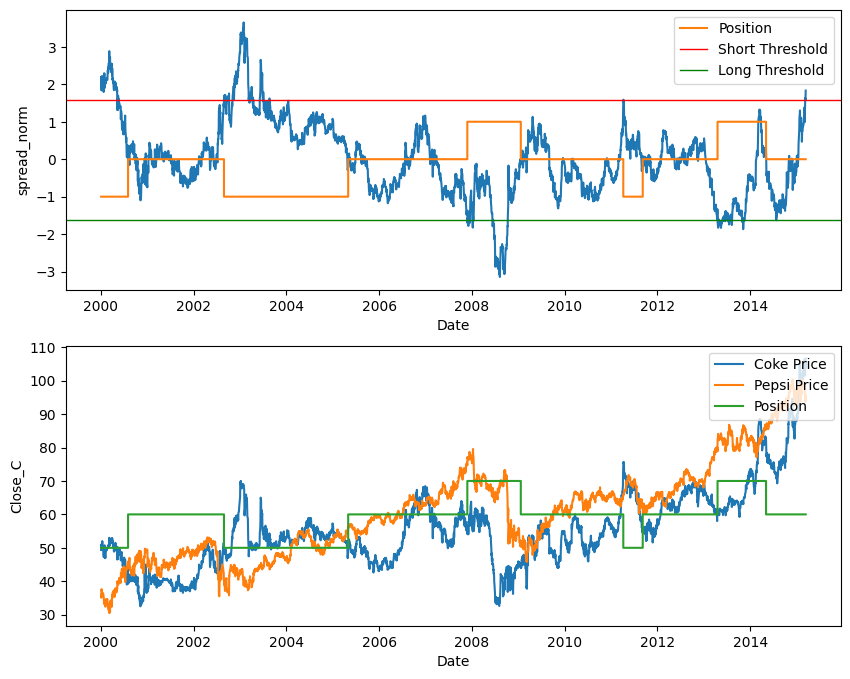

In [201]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

df_train['best_stance']=best_stance

sns.lineplot(df_train['spread_norm'], ax=ax[0])
sns.lineplot( df_train['best_stance'], ax=ax[0], drawstyle='steps-pre', label='Position')
ax[0].axhline(y=best_pair[0],linewidth=1, color='r', label = 'Short Threshold')
ax[0].axhline(y=best_pair[1],linewidth=1, color='g', label = 'Long Threshold')
ax[0].legend(loc="upper right")


sns.lineplot(df_train['Close_C'], ax=ax[1], label='Coke Price')
sns.lineplot(df_train['Close_P'], ax=ax[1], label='Pepsi Price')
sns.lineplot( ((df_train['best_stance']*10) + 60), ax=ax[1], drawstyle='steps-pre', label='Position')
# ax[1].axhline(y=best_pair[0],linewidth=1, color='r', label = 'Short Threshold')
# ax[1].axhline(y=best_pair[1],linewidth=1, color='g', label = 'Long Threshold')
ax[1].legend(loc="upper right")

# plt.plot(df_train['Close_C'])
# plt.plot(df_train['Close_P'])
# plt.plot(df_train['spread'][:50])

plt.show()

Autoregressive model

In [19]:
# # Build simple autoregressive model to predict spread

# # validation lists
# predictions=[]
# val_indices=[]

# tscv = TimeSeriesSplit()
# print(tscv)
# TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
# for i, (train_index, val_index) in enumerate(tscv.split(df_train)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={df_train.index[train_index[0]]}---{df_train.index[train_index[-1]]}")
#     print(f"  Val:  index={df_train.index[val_index[0]]}---{df_train.index[val_index[-1]]}")



#     # fit model

#     # number of lags (p) = 10
#     # order of differencing (d) = 0 
#     # moving average model q = 1
#     model = ARIMA(df_train.iloc[train_index]['spread'], order=(10,0,1))
#     model_fit = model.fit()

#     # summary of fit model
#     print('ARIMA Fit Summary')
#     print(model_fit.summary())

#     # predict on the validation set
#     model_predictions = model_fit.predict(start=val_index[0], end=val_index[-1], dynamic=True)

#     # store validation results and indices
#     predictions.extend(model_predictions)
#     val_indices.extend(val_index)


# # plot residuals to see if they are gaussian
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot(kind='kde')

# # summary stats of residuals
# print('Residuals Summary')
# print(residuals.describe())

In [20]:
# # Since the mean of the residuals is ~0.0 there isn't a bias in the predictions

# print('Model RMSE:', mean_squared_error(df_train.iloc[val_indices]['spread'].values, predictions, squared=False))
# print('Model R2:', r2_score(df_train.iloc[val_indices]['spread'].values, predictions))

# # plot predicted vs actuals
# pyplot.plot(df_train.iloc[val_indices]['spread'].values)
# pyplot.plot(predictions, color='red')
# pyplot.show()   

Predicted Spread Change

Spread Change = (predicted_spread_t+1 - true_spread_t)/true_spread_t


*Note* Spread can be Zero! This can lead to an inf value. Drop entire records with inf

In [21]:
# # store predicted spread
# df_train['spread_pred']=list(model_fit.predict(start=0, end=len(df_train)-1, dynamics=True))

# # add the predicted change of the spread
# df_train['spread_chng']=(df_train['spread_pred'].shift(-1) - df_train['spread'])/df_train['spread']

# # drop inf/-inf values
# df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_train.dropna(inplace=True)

# df_train['spread_chng'].plot()


### Portfolio Optimization using OU

We can construct a portfolio of holindg A shares of Coke and B shares of Pepsi. 

This yields a portfolio value of X(A,B,t) = A C(t) - B P(t) 

We can alterate the ratio of A/B to test resulting portfolio values.

We can apply MLE to fit the observed portfolio values to an OU process and determine the model parameters (theta, mu, sigma)

*Note:* Code and Methodology inspired by https://arxiv.org/pdf/1411.5062.pdf ; https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/6.1%20Ornstein-Uhlenbeck%20process%20and%20applications.ipynb

In [10]:
def portfolio_value(stock_A, stock_B, fraction_B):

    A=1
    B=fraction_B

    # get value of holding 1$ of each stock
    stock_A = stock_A / stock_A.iloc[0]
    stock_B = stock_B / stock_B.iloc[0]

    # construct portfolio
    portfolio_value = (A * stock_A) - (B * stock_B)
    return portfolio_value

# Using the conditional probability density of X under the OU model, we can derive the average log-likelihood
def OU_log_likelihood(params, *args):

    theta, mu, sigma = params
    X, dt = args 
    n = len(X)

    sigma_tilde_2 = (sigma**2) * (1- (exp(-2 * mu * dt)))/(2 * mu)

    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2

    log_likelihood = (-1/2) * np.log(2 * math.pi) - np.log(math.sqrt(sigma_tilde_2)) - (summation_term/(2 * n * sigma_tilde_2))

    # we need the negative log likelihood because we will be using scipy's minimize instead of maximize
    negative_log_likelihood = -log_likelihood
    
    return negative_log_likelihood


# Minimize the negative log likelihood to get the OU parameters for the maximum log likelihood
def MLE_coeffs(X, dt, tol = 1e-10):
    '''
    Estimates OU Coefficients (theta, mu, sigma) of given array, 
    using MLE estimation

    '''

    # real number constraints for theta, mu and sigma
    bounds = ((None, None), (1e-5, None), (1e-5, None))
    guess = (np.mean(X), 100, 100)
    result = so.minimize(OU_log_likelihood, guess, args=(X,dt), bounds=bounds, tol=tol)
    theta, mu, sigma = result.x
    max_log_likelihood = -result.fun
    return theta, mu, sigma, max_log_likelihood


def max_B_allocation(stock_A, stock_B, dt):
    theta = mu = sigma = fraction_B = 0
    max_log_likelihood = 0

    def compute_coeffs(alloc_B):
        portfolio_values = portfolio_value(stock_A, stock_B, alloc_B)
        coeffs = MLE_coeffs(portfolio_values, dt)
        return coeffs   

    coeff_vectors = np.vectorize(compute_coeffs)
    # B_values = np.arange(start=0.001, stop=1.001, step=0.001)
    B_values = np.arange(start=0.01, stop=1.01, step=0.01)
    results = coeff_vectors(B_values)
    max_index = np.argmax(results[3])

    return results[0][max_index], results[1][max_index], results[2][max_index], results[3][max_index], results

In [16]:
stock_A = df_train['Close_C']
stock_B = df_train['Close_P']
dt = 1/len(df_train)

theta_star, mu_star, sigma_star, max_likelihood, results = max_B_allocation(stock_A, stock_B, dt)

fraction 0.01


C:\Users\stefa\AppData\Local\Temp\ipykernel_73784\3185956683.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


fraction 0.01
fraction 0.02
fraction 0.03
fraction 0.04
fraction 0.05
fraction 0.060000000000000005
fraction 0.06999999999999999
fraction 0.08
fraction 0.09
fraction 0.09999999999999999
fraction 0.11
fraction 0.12
fraction 0.13
fraction 0.14
fraction 0.15000000000000002
fraction 0.16
fraction 0.17
fraction 0.18000000000000002
fraction 0.19
fraction 0.2
fraction 0.21000000000000002
fraction 0.22
fraction 0.23
fraction 0.24000000000000002
fraction 0.25
fraction 0.26
fraction 0.27
fraction 0.28
fraction 0.29000000000000004
fraction 0.3
fraction 0.31
fraction 0.32
fraction 0.33
fraction 0.34
fraction 0.35000000000000003
fraction 0.36000000000000004
fraction 0.37
fraction 0.38
fraction 0.39
fraction 0.4
fraction 0.41000000000000003
fraction 0.42000000000000004
fraction 0.43
fraction 0.44
fraction 0.45
fraction 0.46
fraction 0.47000000000000003
fraction 0.48000000000000004
fraction 0.49
fraction 0.5
fraction 0.51
fraction 0.52
fraction 0.53
fraction 0.54
fraction 0.55
fraction 0.56
fraction 

In [17]:
print(theta_star, mu_star, sigma_star, max_likelihood)

0.7562737795741359 12.890385217643004 1.2105420043806026 2.515828141929635


Plot OU Parameter Fitting

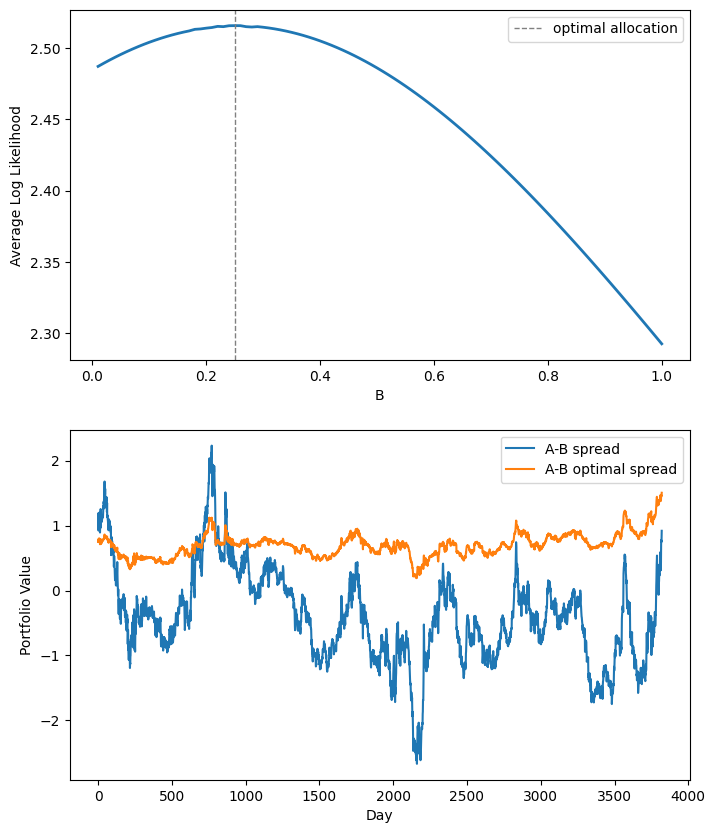

In [18]:
# Determine optimal portfolio allocation
b_alloc = np.arange(start=0.01, stop=1.01, step=0.01)
beta_star = b_alloc[np.argmax(results[3])]

fig = plt.figure(figsize=(8, 10))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(313)
ax1.plot(b_alloc, results[3], linewidth=2)
ax1.set_ylabel("Average Log Likelihood")
ax1.set_xlabel("B")
ax1.axvline(x=beta_star,linewidth=1,linestyle="dashed", color='grey', label = 'optimal allocation')
ax1.legend()

optimal_spread = (df_train['Close_C']/df_train['Close_C'].iloc[0]) - beta_star * (df_train['Close_P']/df_train['Close_P'].iloc[0])

ax2.plot(np.arange(start=0, stop=len(df_train), step=1), (df_train['spread']/df_train['spread'].iloc[0]), label = "A-B spread")
ax2.plot(np.arange(start=0, stop=len(df_train), step=1), optimal_spread, label = "A-B optimal spread")
ax2.set_ylabel("Portfolio Value")
ax2.set_xlabel("Day")
ax2.legend()

### OU Model

Since we have solved for the theta, mu, sigma coefficients of the portfolio value OU problem,
we can model the OU Solution dynamics. Later we can generate simulations and solve for the optimal thresholds.

OU Euler Maruyama numerical method:

X[:,t+1] = X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(dt) * W[:,t]

Where W(t) is standard Bronian motion


*Note* Code inspired by: https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/6.1%20Ornstein-Uhlenbeck%20process%20and%20applications.ipynb

In [11]:
def OU_model(df_train, theta, kappa, sigma, beta, dt, paths=5000):
   N = len(df_train)  # time steps
   # T = 1
   df =1 
   T_vec = np.arange(0, N, dt)


   # theta = 0.774
   # kappa = 12.740
   # sigma = 1.210
   # beta = 0.24


   std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

   # Emperical OU Path
   emperical_OU_path = (df_train['Close_C']/df_train['Close_C'].iloc[0]) - beta * (df_train['Close_P']/df_train['Close_P'].iloc[0])

   X0 = emperical_OU_path.iloc[0]
   X = np.zeros((paths, N))
   X[:, 0] = X0
   W = ss.norm.rvs(loc=0, scale=1, size=(paths, N - 1))

   # Euler Maruyama numerical method
   for t in range(0,N-1):
      X[:,t+1] = X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(dt) * W[:,t]


   X_T = X[:, -1]  # values of X at time T
   X_1 = X[1, :]  # a single path

   return X, X0, std_asy, emperical_OU_path

In [204]:
X, X0, std_asy,emperical_OU_path = OU_model(df_train, theta_star, mu_star, sigma_star, beta_star, dt)

Plot the Simulated and Empirical OU Paths

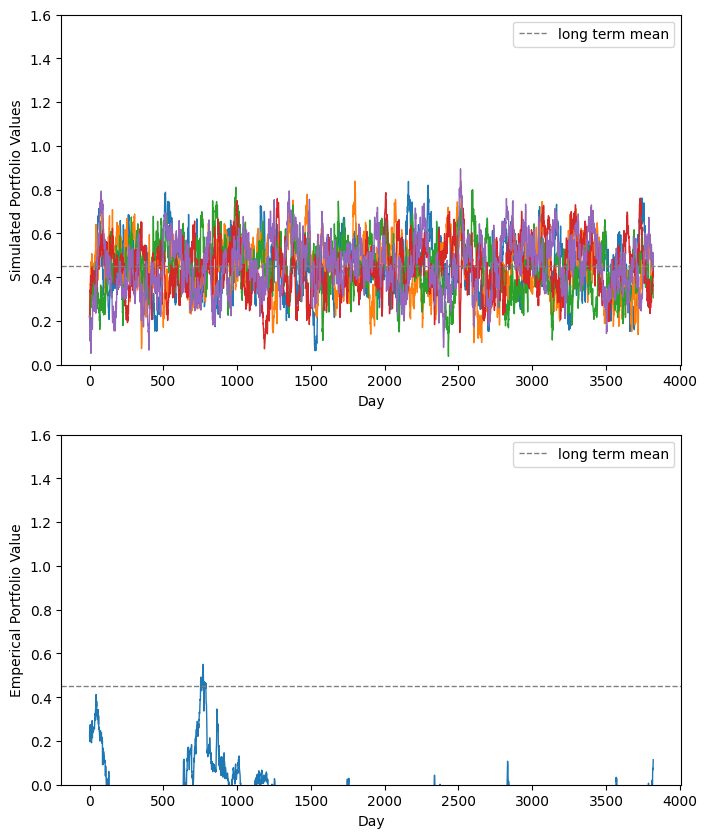

In [205]:
fig = plt.figure(figsize=(8, 10))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(0,5):
    ax1.plot(np.arange(start=0, stop=len(df_train)), X[i, :], linewidth=1)
    ax1.set_ylim([0, 1.6])
    ax1.set_ylabel("Simulated Portfolio Values")
    ax1.set_xlabel("Day")
ax1.axhline(y=theta_star,linewidth=1,linestyle="dashed", color='grey', label = 'long term mean')
ax1.legend()

ax2.plot(np.arange(start=0, stop=len(df_train)), emperical_OU_path, linewidth=1)
ax2.set_ylim([0, 1.6])
ax2.set_ylabel("Emperical Portfolio Value")
ax2.set_xlabel("Day")
ax2.axhline(y=theta_star,linewidth=1,linestyle="dashed", color='grey', label = 'long term mean')
ax2.legend()

Use Simulated Paths to validate OU parameters

In [12]:
def simulated_OU_parameters(path, dt):
    theta = mu = sigma = 0
    max_log_likelihood = 0

    def compute_sim_params():
        portfolio_values = path
        coeffs = MLE_coeffs(portfolio_values, dt)
        return coeffs   

    coeff_vectors = np.vectorize(compute_sim_params)
    results = coeff_vectors()

    return results[0], results[1], results[2], results[3], results

In [207]:

dt = 1/len(df_train)

sim_theta=[]
sim_mu=[]
sim_sigma=[]
sim_max_likelihood=[]

for i,path in enumerate(X):
    # print(f'run: {i}/{len(X)}')
    theta_star, mu_star, sigma_star, max_likelihood, results = simulated_OU_parameters(path, dt)
    
    sim_theta.append(theta_star)
    sim_mu.append(mu_star)
    sim_sigma.append(sigma_star)
    sim_max_likelihood.append(max_likelihood)

simulated_theta = sum(sim_theta)/len(sim_theta)
simulated_mu = sum(sim_mu)/len(sim_mu)
simulated_sigma = sum(sim_sigma)/len(sim_sigma)
simulated_max_likelihood = sum(sim_max_likelihood)/len(sim_max_likelihood)

print('Emperical theta:', theta_star, 'Simulated theta:', simulated_theta)
print('Emperical mu:', mu_star, 'Simulated mu:', simulated_mu)
print('Emperical sigam:', sigma_star, 'Simulated sigma:', simulated_sigma)
# print('Emperical max likelihood:', max_likelihood, 'Simulated max likelihood:', simulated_max_likelihood)
print('Simulated max likelihood:', simulated_max_likelihood)

Emperical theta: 0.4467691928732644 Simulated theta: 0.45037301920072303
Emperical mu: 143.50878195922135 Simulated mu: 169.47089010856308
Emperical sigam: 2.1552285527170594 Simulated sigma: 2.173183232987731
Simulated max likelihood: 1.9510820264394269


### OU Stopping Times

Methodology for determining the short-long thresholds are as follows:

1) Set two bands above and below the asymptotic mean of the OU process (at one asymptotic standard deviation) for opening a short or long position
2) Go short if the upper band is crossed
3) Go long if the lower band is crossed
4) Set two smaller bands to close the position (usually at 1/10th of the standard deviation)


For an OU process, the asymptotic variance is: <br>
    asymptotic variance = (sigma**2)/2*kappa <br>
    asymptotic std = sqrt(asymptotic variance)

*Note:* Code inspired by https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/6.1%20Ornstein-Uhlenbeck%20process%20and%20applications.ipynb

In [13]:
def strategy(X, X0, mean=0, std_open=0.5, std_close=0.05, TC=0):
    """Implementation of the strategy.
        - std_open = levels for opening the position.
        - std_close = levels for closing the position.
        - TC = Transaction costs
    Returns:
        - status:  at each time says if we are long=1, short=-1 or we have no open positions = 0
        - cash: the cumulative amount of cash gained by the strategy.
        At terminal time if there is an open position, it is closed.
    """
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    cash[0] = X0
    idx_list =[]
    for i, x in enumerate(X):
        if (i ==0) and (x <= mean - std_open):
            status[i] = 1
            cash[i] -= x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and (x >= mean + std_open):
            status[i] = -1
            cash[i] += x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and ((mean - std_open) < x < (mean + std_open)):
            continue

        elif (status[i - 1] == 1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
        elif (status[i - 1] == 0) and (x >= mean + std_open):
            status[i] = -1
            cash[i] += x * (1 + TC)
            idx_list.append(i)
        elif (status[i - 1] == 0) and (x <= mean - std_open):
            status[i] = 1
            cash[i] -= x * (1 + TC)
            idx_list.append(i)
        else:
            status[i] = status[i - 1]

    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum(), idx_list

In [39]:
asy_std = np.sqrt(sigma_star**2/ (2 * mu_star))
std_10 = asy_std/10
X0 = emperical_OU_path.iloc[0]

status, cash, idx_list = strategy(X[1,:],X0, mean=theta_star, std_open=std_asy, std_close=std_10, TC=0)

In [42]:
PnL = []  # Profit and loss for this strategy
paths = 5000
for i in range(paths):
    PnL.append(strategy(X[i],X0, mean=theta_star, std_open=std_asy, std_close=std_10, TC=0)[1][-1])
PnL = np.array(PnL)

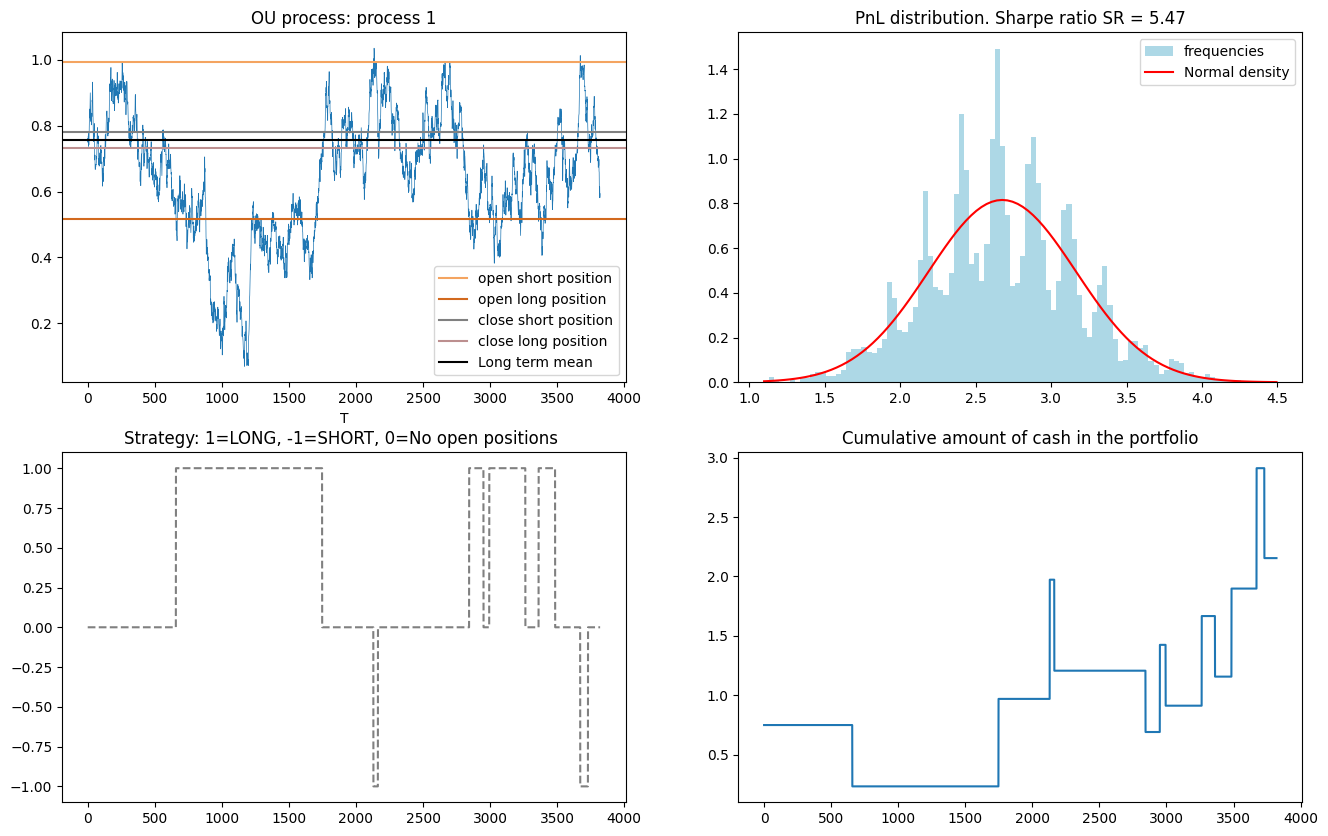

In [43]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
ax1.plot(np.arange(0,len(df_train),1), X[1, :], linewidth=0.5)
ax1.axhline(y = (theta_star + std_asy), label="open short position", color="sandybrown")
ax1.axhline(y = (theta_star - std_asy), label="open long position", color="chocolate")
ax1.axhline(y = (theta_star + std_10), label="close short position", color="gray")
ax1.axhline(y = (theta_star - std_10), label="close long position", color="rosybrown")
ax1.axhline(y = theta_star, label="Long term mean", color="black")
ax1.legend()
ax1.set_title(f"OU process: process {1}")
ax1.set_xlabel("T")

ax2.plot(np.arange(0,len(df_train),1), status, linestyle="dashed", color="grey")
ax2.set_title("Strategy: 1=LONG, -1=SHORT, 0=No open positions ")

ax3.hist(PnL, density=True, bins=100, facecolor="LightBlue", label="frequencies")
x = np.linspace(PnL.min(), PnL.max(), 100)
ax3.plot(x, ss.norm.pdf(x, loc=PnL.mean(), scale=PnL.std()), color="r", label="Normal density")
SR = PnL.mean() / PnL.std()
ax3.legend()
ax3.set_title(f"PnL distribution. Sharpe ratio SR = {SR.round(2)}")

ax4.plot(np.arange(0,len(df_train),1), cash)
ax4.set_title("Cumulative amount of cash in the portfolio")
plt.show()

### OU Optimized Stopping Times 

Since we have an OU simulation that represents our Pairs portfolio value, we can run this simulation across different threshold ranges to see which optimizes the PnL Shapre Ratio

We can try 0.5 - 1.5 standard deviations away from the asymptotic mean to open the short/long positions. <br>
We can try 0 - 0.25 standard deviations away from the asymptotic mean to close the short/long positions. 

In [14]:
def optimal_bollinger_thresholds(X, X0, theta, asy_std, paths):    

    # Limits for opening long/short position
    asy_std_upper = 1.5 * asy_std
    asy_std_lower = 0.5 * asy_std

    # Limits for closing long/short position
    std_4 = asy_std/4
    std_0 = 0

    # Range for opening long/short positions
    open_range = np.linspace(start=asy_std_upper, stop=asy_std_lower, num=20)

    # Range for closing long/short positions
    close_range = np.linspace(start=std_0, stop=std_4, num=20)

    # Create param_grid space
    # Every combination of aS with aL
    threshold_pairs=[]
    for i in range(len(open_range)):
        for j in range(len(close_range)):
            threshold_pairs.append((open_range[i], close_range[j]))

    PnL_best = []
    SR_best = 0
    pair_best =(0,0)

    for q,p in enumerate(threshold_pairs):
        # print(f'run: {q}/{len(threshold_pairs)}')
        PnL = []  # Profit and loss for this strategy
        for i in range(paths):
            PnL.append(strategy(X[i], X0, mean=theta, std_open=p[0], std_close=p[1], TC=0)[1][-1])
        PnL = np.array(PnL)
        SR = PnL.mean() / PnL.std()
        
        if SR > SR_best:
            SR_best = SR
            pair_best = (p[0],p[1])
            PnL_best = PnL
    
    return PnL_best, pair_best, SR_best

In [46]:
PnL_best, pair_best, SR_best = optimal_bollinger_thresholds(X, X0, theta_star, asy_std, paths)

KeyboardInterrupt: 

In [ ]:
status, cash = strategy(X[1,:], X0, mean=theta_star, std_open=pair_best[0], std_close=pair_best[1], TC=0)

NameError: name 'theta' is not defined

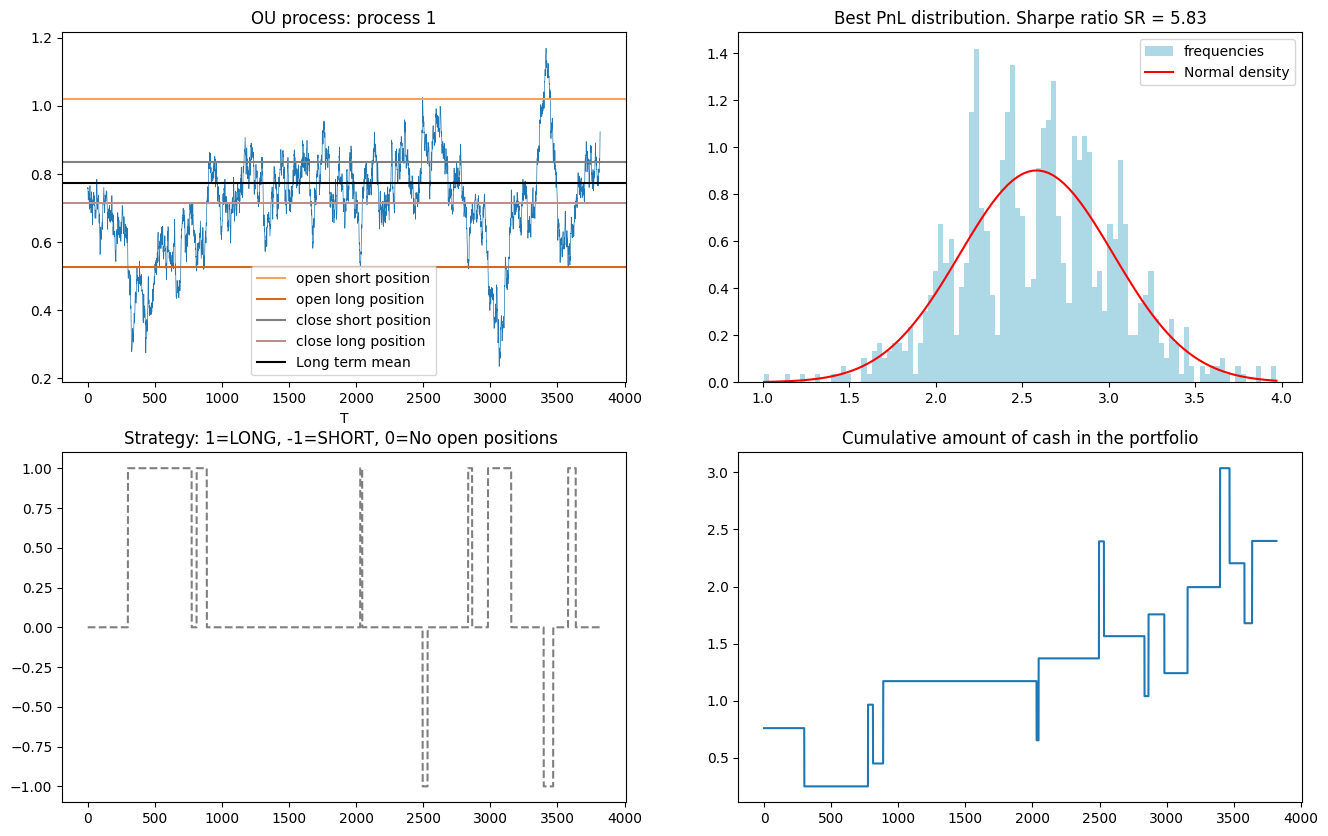

In [1330]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
ax1.plot(np.arange(0,len(df_train),1), X[1, :], linewidth=0.5)
ax1.axhline(y = (theta + pair_best[0]), label="open short position", color="sandybrown")
ax1.axhline(y = (theta - pair_best[0]), label="open long position", color="chocolate")
ax1.axhline(y = (theta + pair_best[1]), label="close short position", color="gray")
ax1.axhline(y = (theta - pair_best[1]), label="close long position", color="rosybrown")
ax1.axhline(y = theta, label="Long term mean", color="black")
ax1.legend()
ax1.set_title(f"OU process: process {1}")
ax1.set_xlabel("T")

ax2.plot(np.arange(0,len(df_train),1), status, linestyle="dashed", color="grey")
ax2.set_title("Strategy: 1=LONG, -1=SHORT, 0=No open positions ")

ax3.hist(PnL_best, density=True, bins=100, facecolor="LightBlue", label="frequencies")
x = np.linspace(PnL_best.min(), PnL_best.max(), 100)
ax3.plot(x, ss.norm.pdf(x, loc=PnL_best.mean(), scale=PnL_best.std()), color="r", label="Normal density")
SR = PnL_best.mean() / PnL_best.std()
ax3.legend()
ax3.set_title(f"Best PnL distribution. Sharpe ratio SR = {SR.round(2)}")

ax4.plot(np.arange(0,len(df_train),1), cash)
ax4.set_title("Cumulative amount of cash in the portfolio")
plt.show()

## Johnson SU Distribution Fitting

Code inspired by https://colab.research.google.com/drive/1LP6PTDLVwn-EBCZkCQOwmAtvJJcxAuvb

https://stackoverflow.com/questions/45845364/what-are-the-a-and-b-parameters-in-scipy-stats-johnsonsu

In [178]:
# def normal_mle(k , emperical_spread):

#     n = len(emperical_spread)

#     ll = -n * np.log(k[1]*(2*np.pi)**(1/2)) - np.sum(((emperical_spread - k[0])**2)/2*k[1]**2)

#     return -ll

In [182]:
# def normal_distribution(emperical_spread):
    
#     emperical_mean = emperical_spread.mean()
#     emperical_std = np.std(emperical_spread)

#     # call Johnson SU optimization
#     params = so.minimize(normal_mle, [emperical_mean, emperical_std, 0, 1], args=(emperical_spread), method = 'Nelder-Mead')

#     # parameters
#     mu = params.x[0]
#     sigma = params.x[1]

#     # calculate the pdf of the normal distribution

#     exponent = (-1*(emperical_spread-mu)**2)/(2*sigma**2)
#     pdf = np.exp(exponent)/ (sigma * (2*np.pi)**2)

#     # calculate the cumulative distribution function and emperical distribution function
#     cdf = ss.norm.cdf(pdf)

#     # evaluate goodness-of-fit using Kolmogorov-Smirnov test
#     test_statistics = ss.kstest(emperical_spread, cdf)

#     if test_statistics[1] < 0.1:
#         print('The distribution does not fit the data')
#         return
#     else:
#         print('The distribution fits the data')
#         return mu,sigma

In [47]:
# #optimise Johnson SU distribution parameters using maximum likelihood estimation
# def johnson_su_optimisation(k,sorted_OU_path):
#     k[1] = abs(k[1])
#     k[3] = abs(k[3])
#     pdf = k[3]/(k[1]*(2*np.pi)**(1/2))/(1 + ((sorted_OU_path - k[0])/k[1])**2)**(1/2)*np.exp(-1/2*(k[2] + k[3]*np.arcsinh((sorted_OU_path - k[0])/k[1]))**2)

#     return -np.sum(np.log(pdf)) # return negative of MLE because scipy's minimize function

In [142]:
# def johnson_distribution(emperical_spread):
    
#     # sort emperical spread
#     sorted_spread = np.sort(emperical_spread)

#     # calculate mean and std of sorted spread
#     emperical_mean =  sorted_spread.mean()
#     emperical_std = np.std(sorted_spread)

#     # call Johnson SU optimization
#     su_params = so.minimize(johnson_su_optimisation, [emperical_mean, emperical_std, 0, 1], args=(sorted_spread), method = 'Nelder-Mead')

#     # parameters
#     su_1 = su_params.x[0]
#     su_2 = abs(su_params.x[1])
#     su_3 = su_params.x[2]
#     su_4 = abs(su_params.x[3])

#     # calculate the cumulative distribution function and emperical distribution function
#     cdf = ss.norm.cdf(su_3 + su_4*np.arcsinh((sorted_spread - su_1)/su_2))
#     edf = np.arange(1, len(sorted_spread)+1)/len(sorted_spread)

#     # # plot cdf
#     # plt.plot(sorted_spread, edf)
#     # plt.plot(sorted_spread, cdf)
#     # plt.show()

#     #evaluate the goodness-of-fit using Kolmogorov-Smirnov test
#     supremum = max(abs(edf - cdf))
#     p_value = np.exp(-supremum**2*len(sorted_spread))

#     if p_value < 0.1:
#         print('The distribution does not fit the data')
#         return
#     else:
#         print('The distribution fits the data')
#         return cdf, su_1, su_2, su_3, su_4

## V-Ratio Test

code inspired by https://www.youtube.com/watch?v=upogJg7YbJo

In [19]:
def vratio_strategy(X,X0,vratios, mean=0, std_open=0.5, std_close=0.5, TC=0, trend_max=3):
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    trend_counter = 0
    idx_list = []

    for i,x in enumerate(X):

        if (i ==0) and (x <= mean - std_open) and (vratios[i] == -1):
            status[i] = 1
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and (x >= mean + std_open) and (vratios[i] == -1):
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and ((mean - std_open) < x < (mean + std_open)):
            continue

        elif (status[i-1]==1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
            trend_counter = 0 

        elif (status[i-1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
            trend_counter = 0

        elif (status[i -1] == 0) and (x >= mean + std_open) and (vratios[i] == -1): 
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 +TC)
            idx_list.append(i)

        elif (status[i-1]== 0) and (x >= mean + std_open) and (vratios[i] == 1) and (trend_counter == trend_max):
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 + TC)
            idx_list.append(i)

        elif (status[i-1] == 0) and (x >= mean + std_open) and (vratios[i] == 1) and (trend_counter < trend_max):
            status[i] = 0
            trend_counter += 1

        elif (status[i-1] == 0) and (x <= mean - std_open) and (vratios[i] == -1):
            status[i] = 1
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)

        elif (status[i-1] == 0) and (x <= mean - std_open) and (vratios[i] == 1) and (trend_counter == trend_max):
            status[i] = 1 
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)
            
        elif (status[i-1] == 0) and (x <= mean - std_open) and (vratios[i] == 1) and (trend_counter < trend_max):
            status[i] = 0
            trend_counter += 1

        else:
            status[i] = status[i-1]
    
    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum(), idx_list

In [20]:
def vratio_test(df, max_t):
    n = len(df)
    # n = df.size
    var0 = df.var()
    variance_ratio_output = pd.DataFrame()
    cd=0
    
    for t in np.arange(2, max_t+1):
        variance = df.rolling(t).sum().var()
        variance_ratio = variance/(t*var0) - 1 
        standard_error = (2*(2*t-1)*(t-1)/(3*t*n))**(1/2)
        z_stat = variance_ratio/standard_error
        p_value = 2*(1 - ss.norm.cdf(abs(z_stat)))
        variance_ratio_output[t] = [round(var0,3), round(variance,3), round(variance_ratio,3), round(z_stat,3), p_value]
    
    min_p_value = min(variance_ratio_output.iloc[4])
    chow_denning = 1 - (1 - min_p_value)**(max_t - 1)
    max_z_stat = variance_ratio_output.iloc[3][variance_ratio_output.iloc[4] == min_p_value].values[0]
    if chow_denning > 0.1:
        # print('the market is efficient')
        cd = 1
    elif max_z_stat > 0:
        # print('the market is trending')
        cd = 1
    else:
        # print('the market is mean-reverting')
        cd = -1
    
    return cd

In [38]:
def lstm_strategy(X,X0,lstm_predictions, mean=0, std_open=0.5, std_close=0.5, TC=0, trend_max=3):
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    trend_counter = 0
    idx_list = []

    for i,x in enumerate(X):

        if (i ==0) and (x <= mean - std_open) and (lstm_predictions[i] > x):
            status[i] = 1
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and (x >= mean + std_open) and (lstm_predictions[i] < x):
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 + TC)
            idx_list.append(i)

        elif (i==0) and ((mean - std_open) < x < (mean + std_open)):
            continue

        elif (status[i-1]==1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
            trend_counter = 0 

        elif (status[i-1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
            trend_counter = 0

        elif (status[i -1] == 0) and (x >= mean + std_open) and (lstm_predictions[i] < x): 
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 +TC)
            idx_list.append(i)

        elif (status[i-1]== 0) and (x >= mean + std_open) and (lstm_predictions[i] > x) and (trend_counter == trend_max):
            status[i] = -1
            trend_counter = 0
            cash[i] += x * (1 + TC)
            idx_list.append(i)

        elif (status[i-1] == 0) and (x >= mean + std_open) and (lstm_predictions[i] > x) and (trend_counter < trend_max):
            status[i] = 0
            trend_counter += 1

        elif (status[i-1] == 0) and (x <= mean - std_open) and (lstm_predictions[i] > x):
            status[i] = 1
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)

        elif (status[i-1] == 0) and (x <= mean - std_open) and (lstm_predictions[i] < x) and (trend_counter == trend_max):
            status[i] = 1 
            trend_counter = 0
            cash[i] -= x * (1 + TC)
            idx_list.append(i)
            
        elif (status[i-1] == 0) and (x <= mean - std_open) and (lstm_predictions[i] < x) and (trend_counter < trend_max):
            status[i] = 0
            trend_counter += 1

        else:
            status[i] = status[i-1]
    
    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum(), idx_list

In [60]:
def lstm_predictions(window, model):
    pred = model.predict(window)

    return pred[-1]

## Determine Optimal Parameter Range

We need to determine a daterange in which to optimize the bollinger thresholds. Going too far back will include stale stale data, and going too near the present moment may not include enough training data.

In order to accmomplish this, we can fix a validation range (at the end of our training range), and take increasingly larger segments of training data that precedes the validation range. The length of the training segment that maximizes performance can be taken as the range on which to train the bollinger thresholds. 

In [108]:
# Validation range of 1 Quarter length (91 days)
df_val = df_train[-91:]
cash_best = 0
SR_best=0
PnL_best = 0 
pair_best = 0
m_best=0

# Try different multiples of 91 days up to two years
for m in range(2,10):
    print(f'training with quarter: {m-1}/8')

    # Get training range
    df_split = df_train[-m*91:-91]

    # Solve OU parameters
    stock_A = df_split['Close_C']
    stock_B = df_split['Close_P']
    dt = 1/len(df_split)
    paths = 1000  # number of paths

    # Call OU optimizer
    theta_star, mu_star, sigma_star, max_likelihood, results = max_B_allocation(stock_A, stock_B, dt)

    # Get Hedge Ratio
    b_alloc = np.arange(start=0.01, stop=1.01, step=0.01)
    beta_star = b_alloc[np.argmax(results[3])]

    # Create emperical OU Spread
    emperical_OU = (df_split['Close_C']/df_split['Close_C'].iloc[0]) - beta_star * (df_split['Close_P']/df_split['Close_P'].iloc[0])
    emperical_OU_val = (df_val['Close_C']/df_val['Close_C'].iloc[0]) - beta_star * (df_val['Close_P']/df_val['Close_P'].iloc[0])

    # Get OU Model
    X,X0, std_asy = OU_model(df_split, theta_star, mu_star, sigma_star, beta_star, dt, paths)

    # Get bollinger thresholds
    PnL, pair, SR = optimal_bollinger_thresholds(X,X0, emperical_OU.mean(), asy_std, paths)


    # Test performance on validation set
    X0_val = emperical_OU_val.iloc[0]
    status, cash = strategy(emperical_OU_val, X0_val, mean=emperical_OU_val.mean(), std_open=pair[0], std_close=pair[1], TC=0)

    # Update best run
    if cash[-1] > cash_best:
        PnL_best = PnL
        SR_best = SR
        cash_best = cash[-1]
        m_best = m    

training with quarter: 1/8


C:\Users\stefa\AppData\Local\Temp\ipykernel_34236\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


training with quarter: 2/8
training with quarter: 3/8
training with quarter: 4/8
training with quarter: 5/8
training with quarter: 6/8
training with quarter: 7/8
training with quarter: 8/8


In [110]:
print('The optimal amount of quarters to use for determining bollinger is:', m_best-1)

The optimal amount of quarters to use for determining bollinger is: 2


## Trading System

Perform these steps everyday 

1) Within a rolling window (10 days), fit a Johnson_SU distribution to the optimal spread
2) Simulate a Johnson_SU distribution using the MLE parameters, and calculate the ci intervals
3) If spread crosses OU bollinger long band, buy X amount of Coke shares and short 0.24 X amount of Pepsi shares
4) If spread crosses OU bollinger short band, sell X amoutn of Coke shares and buy 0.24 X amount of Pespi shares 
5) Compare the ci level of the Johnson_SU at the time of buying to decide whether to exit early or not

total records 1204
.....Splitting Data.....
.....Solving OU Parameters.....


C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 1s 6ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 331ms/step
window Date
2019-10-11    0.371879
2019-10-14    0.366673
2019-10-15    0.360402
2019-10-16    0.374720
2019-10-17    0.374193
2019-10-18    0.358586
2019-10-21    0.374342
2019-10-22    0.329087
2019-10-23    0.278950
2019-10-24    0.300772
2019-10-25    0.288358
2019-10-28    0.287408
2019-10-29    0.288043
2019-10-30    0.303041
2019-10-31    0.294916
2019-11-01    0.290491
2019-11-04    0.253996
2019-11-05    0.275510
2019-11-06    0.279276
2019-11-07    0.278601
dtype: float64
last pred [0.40622336]
1/1 [==============================] - 0s 21ms/step
window Date
2019-10-14    0.366673
2019-10-15    0.360402
2019-10-16    0.374720
2019-10-17    0.374193
2019-10-18    0.358586
2019-1

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 16ms/step
window Date
2020-02-24    0.513123
2020-02-25    0.479173
2020-02-26    0.270842
2020-02-27    0.257109
2020-02-28    0.256733
2020-03-02    0.340302
2020-03-03    0.309384
2020-03-04    0.295536
2020-03-05    0.273207
2020-03-06    0.275302
2020-03-09    0.275311
2020-03-10    0.343547
2020-03-11    0.310091
2020-03-12    0.366300
2020-03-13    0.368295
2020-03-16    0.365774
2020-03-17    0.364860
2020-03-18    0.352678
2020-03-19    0.345738
2020-03-20    0.370812
dtype: float64
last pred [0.3824792]
1/1 [==============================] - 0s 11ms/step
window Date
2020-02-25    0.479173
2020-02-26    0.270842
2020-02-27    0.257109
2020-02-28    0.256733
2020-03-02    0.340302
2020-03-

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 23ms/step
window Date
2020-07-02    0.356406
2020-07-06    0.373119
2020-07-07    0.358575
2020-07-08    0.351722
2020-07-09    0.325971
2020-07-10    0.329911
2020-07-13    0.326770
2020-07-14    0.333931
2020-07-15    0.347758
2020-07-16    0.340100
2020-07-17    0.348986
2020-07-20    0.341735
2020-07-21    0.333615
2020-07-22    0.329834
2020-07-23    0.328696
2020-07-24    0.341532
2020-07-27    0.351725
2020-07-28    0.336166
2020-07-29    0.336388
2020-07-30    0.318801
dtype: float64
last pred [0.19890758]
1/1 [==============================] - 0s 28ms/step
window Date
2020-07-06    0.373119
2020-07-07    0.358575
2020-07-08    0.351722
2020-07-09    0.325971
2020-07-10    0.329911
2020-07

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 13ms/step
window Date
2020-11-10    0.278787
2020-11-11    0.285201
2020-11-12    0.260734
2020-11-13    0.273510
2020-11-16    0.303941
2020-11-17    0.319876
2020-11-18    0.325387
2020-11-19    0.327082
2020-11-20    0.305379
2020-11-23    0.301312
2020-11-24    0.332696
2020-11-25    0.307303
2020-11-27    0.298959
2020-11-30    0.290713
2020-12-01    0.286522
2020-12-02    0.273210
2020-12-03    0.288894
2020-12-04    0.266354
2020-12-07    0.263658
2020-12-08    0.264084
dtype: float64
last pred [0.16835606]
1/1 [==============================] - 0s 17ms/step
window Date
2020-11-11    0.285201
2020-11-12    0.260734
2020-11-13    0.273510
2020-11-16    0.303941
2020-11-17    0.319876
2020-11

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 23ms/step
window Date
2021-03-24    0.487181
2021-03-25    0.516185
2021-03-26    0.533201
2021-03-29    0.544373
2021-03-30    0.523691
2021-03-31    0.501109
2021-04-01    0.503781
2021-04-05    0.520132
2021-04-06    0.522511
2021-04-07    0.521460
2021-04-08    0.544922
2021-04-09    0.558748
2021-04-12    0.543736
2021-04-13    0.534243
2021-04-14    0.546854
2021-04-15    0.558363
2021-04-16    0.566175
2021-04-19    0.582991
2021-04-20    0.557344
2021-04-21    0.577999
dtype: float64
last pred [0.24955426]
1/1 [==============================] - 0s 18ms/step
window Date
2021-03-25    0.516185
2021-03-26    0.533201
2021-03-29    0.544373
2021-03-30    0.523691
2021-03-31    0.501109
2021-04

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 24ms/step
window Date
2021-08-03    0.876550
2021-08-04    0.862822
2021-08-05    0.885237
2021-08-06    0.894232
2021-08-09    0.871469
2021-08-10    0.897233
2021-08-11    0.920957
2021-08-12    0.977511
2021-08-13    0.956308
2021-08-16    0.931819
2021-08-17    0.937667
2021-08-18    0.905177
2021-08-19    0.884205
2021-08-20    0.906177
2021-08-23    0.904498
2021-08-24    0.904578
2021-08-25    0.901417
2021-08-26    0.882758
2021-08-27    0.920354
2021-08-30    0.919161
dtype: float64
last pred [0.49674702]
1/1 [==============================] - 0s 20ms/step
window Date
2021-08-04    0.862822
2021-08-05    0.885237
2021-08-06    0.894232
2021-08-09    0.871469
2021-08-10    0.897233
2021-08

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....


C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1988805320.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  SR = PnL.mean() / PnL.std()


.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 18ms/step
window Date
2021-12-10    1.495463
2021-12-13    1.511826
2021-12-14    1.491030
2021-12-15    1.558567
2021-12-16    1.555962
2021-12-17    1.534391
2021-12-20    1.732233
2021-12-21    1.708793
2021-12-22    1.773043
2021-12-23    1.742019
2021-12-27    1.760435
2021-12-28    1.810691
2021-12-29    1.825157
2021-12-30    1.830734
2021-12-31    1.835429
2022-01-03    1.828835
2022-01-04    1.790120
2022-01-05    1.776486
2022-01-06    1.863865
2022-01-07    1.748244
dtype: float64
last pred [1.0218031]
1/1 [==============================] - 0s 18ms/step
window Date
2021-12-13    1.511826
2021-12-14    1.491030
2021-12-15    1.558567
2021-12-16    1.555962
2021-12-17    1.534391
2021-12-20    1.732233
2021-12-21    1.708793
2021-12-22    1.773043
2021-12-23    1.742019
2021-12-27    1.760435
2021-12-28    1.810691
2021-12-29    1.825157
2021-12-30    

c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\4019423057.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  SR = PnL.mean() / PnL.std()
C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 17ms/step
window Date
2022-04-22    0.637543
2022-04-25    0.669880
2022-04-26    0.621717
2022-04-27    0.557612
2022-04-28    0.530521
2022-04-29    0.493395
2022-05-02    0.559536
2022-05-03    0.560857
2022-05-04    0.717135
2022-05-05    0.630066
2022-05-06    0.691723
2022-05-09    0.740616
2022-05-10    0.766707
2022-05-11    0.753325
2022-05-12    0.826658
2022-05-13    0.872858
2022-05-16    0.852970
2022-05-17    0.842948
2022-05-18    0.772642
2022-05-19    0.807751
dtype: float64
last pred [0.51301175]
1/1 [==============================] - 0s 18ms/step
window Date
2022-04-25    0.669880
2022-04-26    0.621717
2022-04-27    0.557612
2022-04-28    0.530521
2022-04-29    0.493395
2022-05

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0694 - root_mean_squared_error: 0.2634
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 22ms/step
window Date
2022-09-01    0.614638
2022-09-02    0.594414
2022-09-06    0.543447
2022-09-07    0.537186
2022-09-08    0.535131
2022-09-09    0.545218
2022-09-12    0.566442
2022-09-13    0.485446
2022-09-14    0.511171
2022-09-15    0.478934
2022-09-16    0.479074
2022-09-19    0.478448
2022-09-20    0.457619
2022-09-21    0.446662
2022-09-22    0.418053
2022-09-23    0.381833
2022-09-26    0.382837
2022-09-27    0.386758
2022-09-28    0.422645
2022-09-29    0.422397
dtype: float64
last pred [0.09434041]
1/1 [==============================] - 0s 28ms/step
window Date
2022-09-02    0.594414
2022-09-06    0.543447
2022-09-07    0.537186
2022-09-08    0.535131
2022-09-09    0.545218
2022-09

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 6ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 17ms/step
window Date
2023-01-12    0.654857
2023-01-13    0.683549
2023-01-17    0.679801
2023-01-18    0.651108
2023-01-19    0.659671
2023-01-20    0.680565
2023-01-23    0.726524
2023-01-24    0.736067
2023-01-25    0.745482
2023-01-26    0.765708
2023-01-27    0.744683
2023-01-30    0.704450
2023-01-31    0.774481
2023-02-01    0.824052
2023-02-02    0.868471
2023-02-03    0.833391
2023-02-06    0.830468
2023-02-07    0.794248
2023-02-08    0.777625
2023-02-09    0.753601
dtype: float64
last pred [0.25787377]
1/1 [==============================] - 0s 18ms/step
window Date
2023-01-13    0.683549
2023-01-17    0.679801
2023-01-18    0.651108
2023-01-19    0.659671
2023-01-20    0.680565
2023-01

C:\Users\stefa\AppData\Local\Temp\ipykernel_142964\1338654335.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summation_term += (X[i] - X[i-1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt)))**2


6/6 [==============================] - 0s 7ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663
.....Call OU Model.....
.....Get Optimal Bollinger Thresholds.....
.....Run Trading System without VRatio.....
.....Run Trading System with VRatio.....
1/1 [==============================] - 0s 17ms/step
window Date
2023-05-24    1.335602
2023-05-25    1.381034
2023-05-26    1.404520
2023-05-30    1.398342
2023-05-31    1.364948
2023-06-01    1.448500
2023-06-02    1.485612
2023-06-05    1.366119
2023-06-06    1.464422
2023-06-07    1.401742
2023-06-08    1.398331
2023-06-09    1.384669
2023-06-12    1.336409
2023-06-13    1.336008
2023-06-14    1.291910
2023-06-15    1.243020
2023-06-16    1.309728
2023-06-20    1.303504
2023-06-21    1.348396
2023-06-22    1.389428
dtype: float64
last pred [0.7026707]
1/1 [==============================] - 0s 18ms/step
window Date
2023-05-25    1.381034
2023-05-26    1.404520
2023-05-30    1.398342
2023-05-31    1.364948
2023-06-01    1.448500
2023-06-

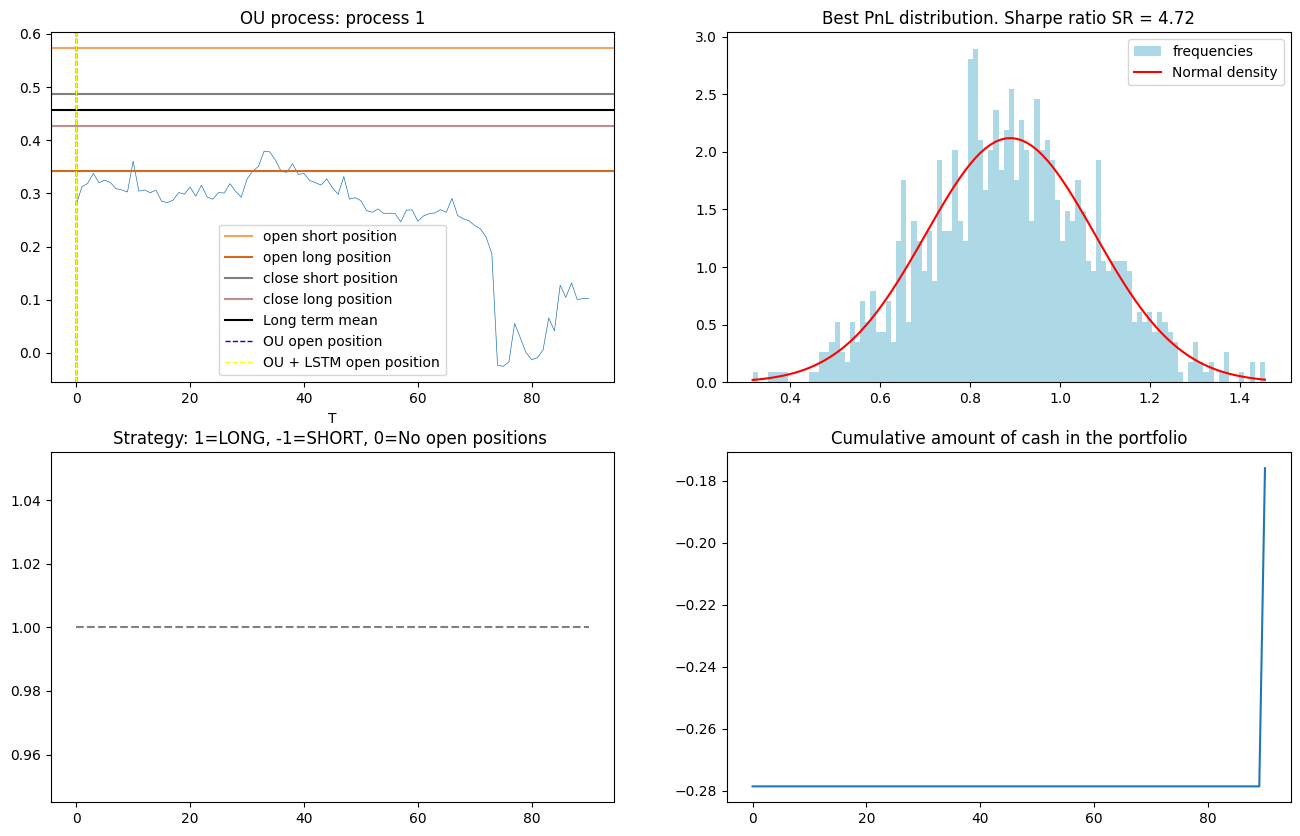

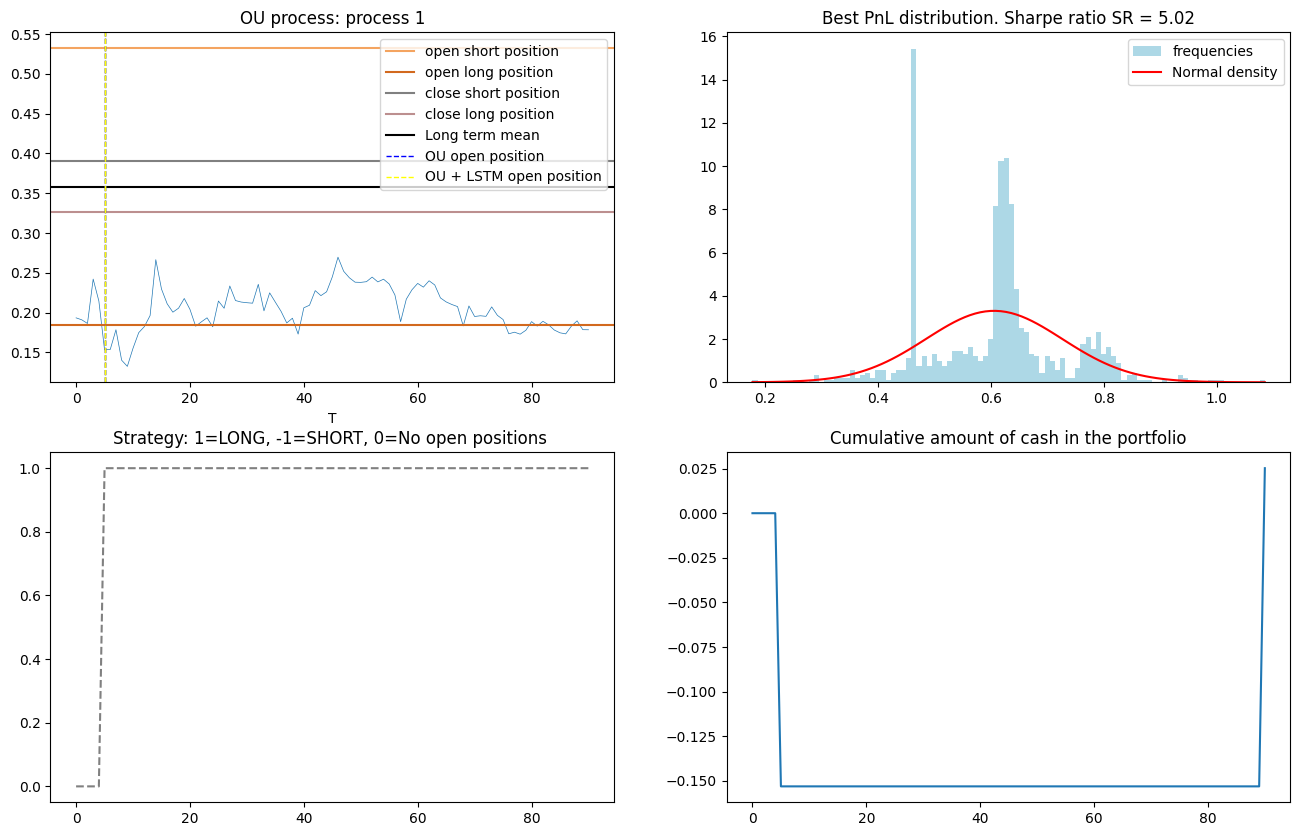

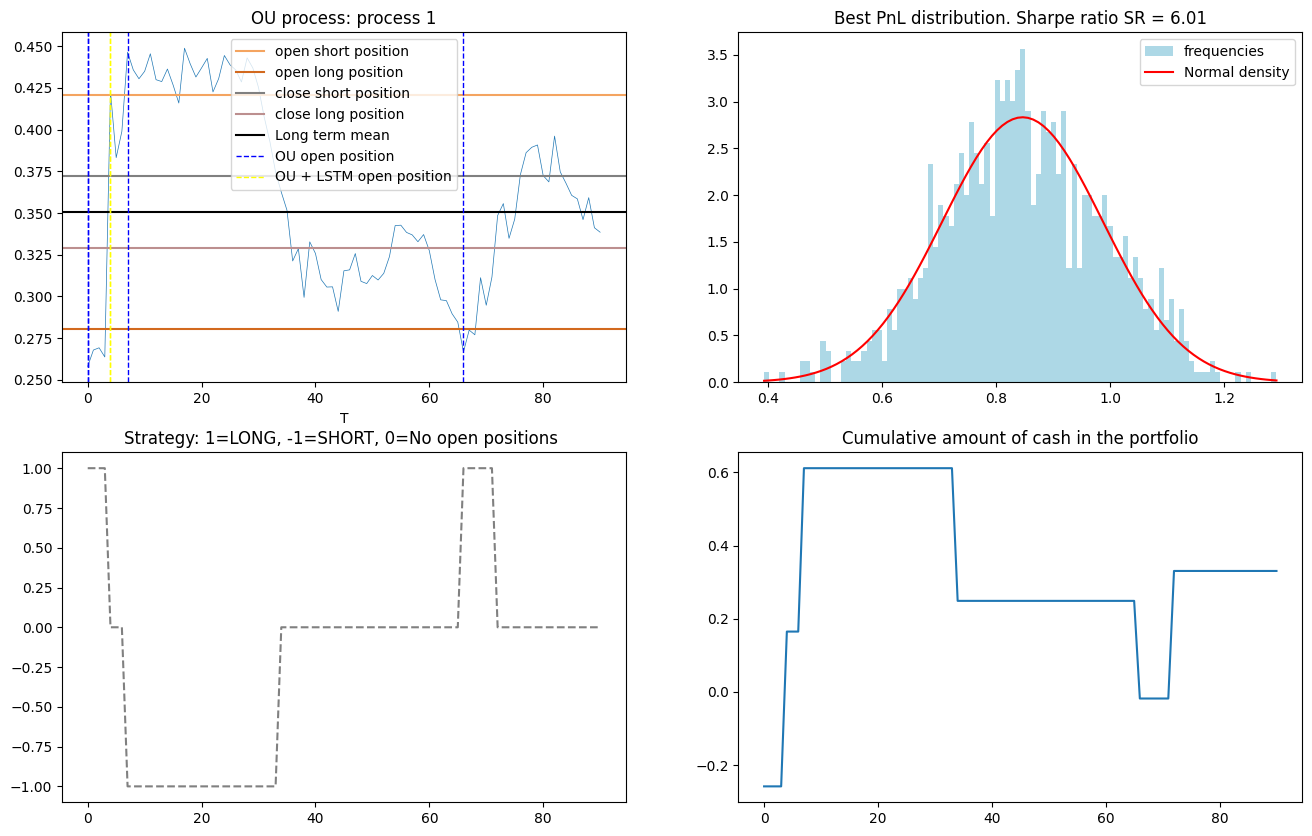

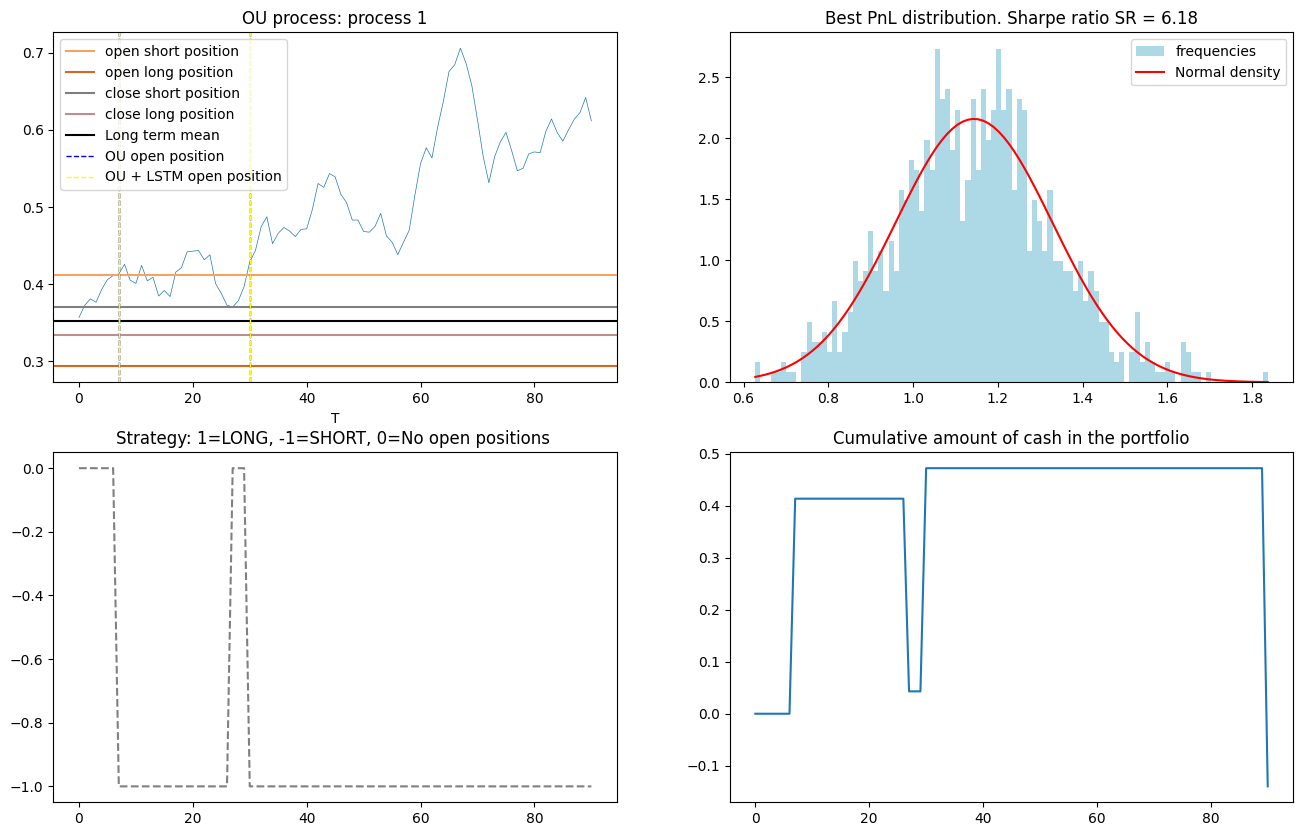

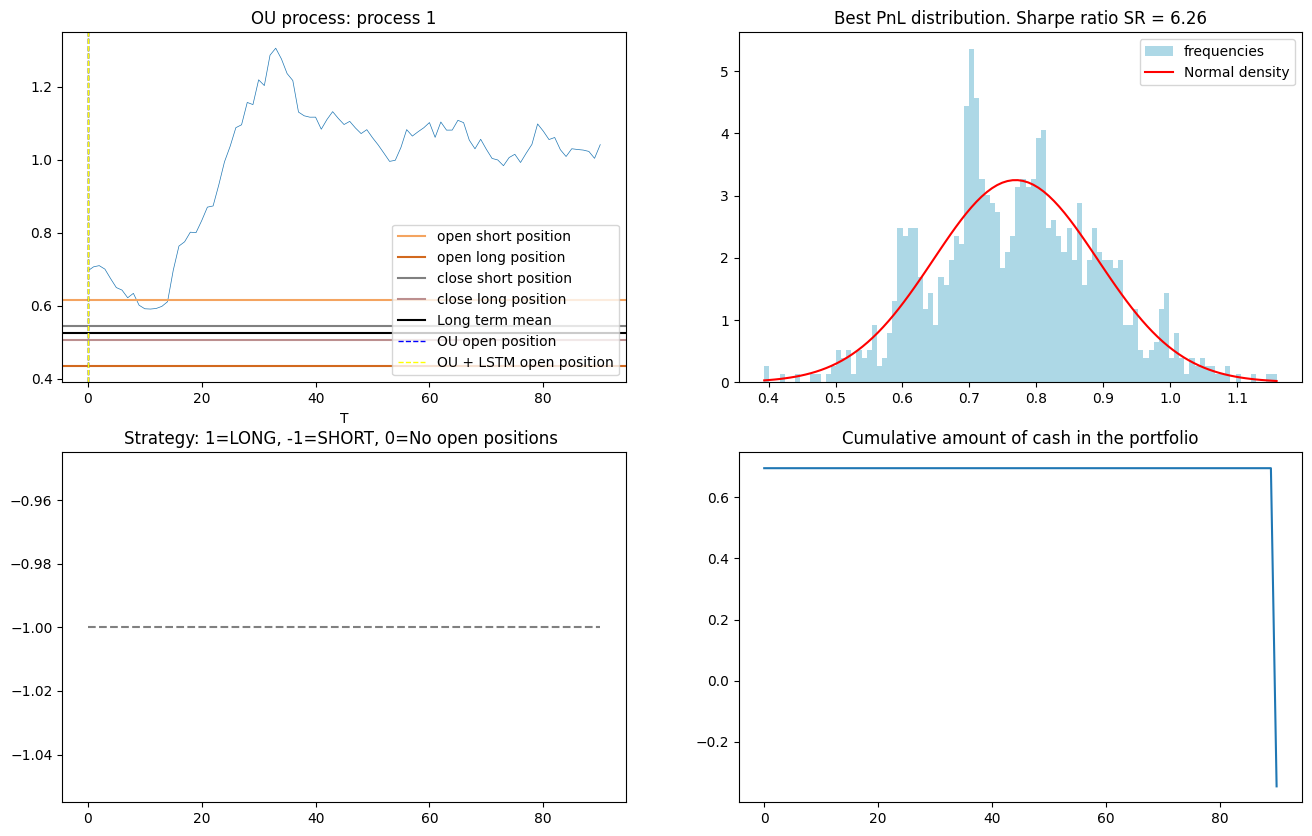

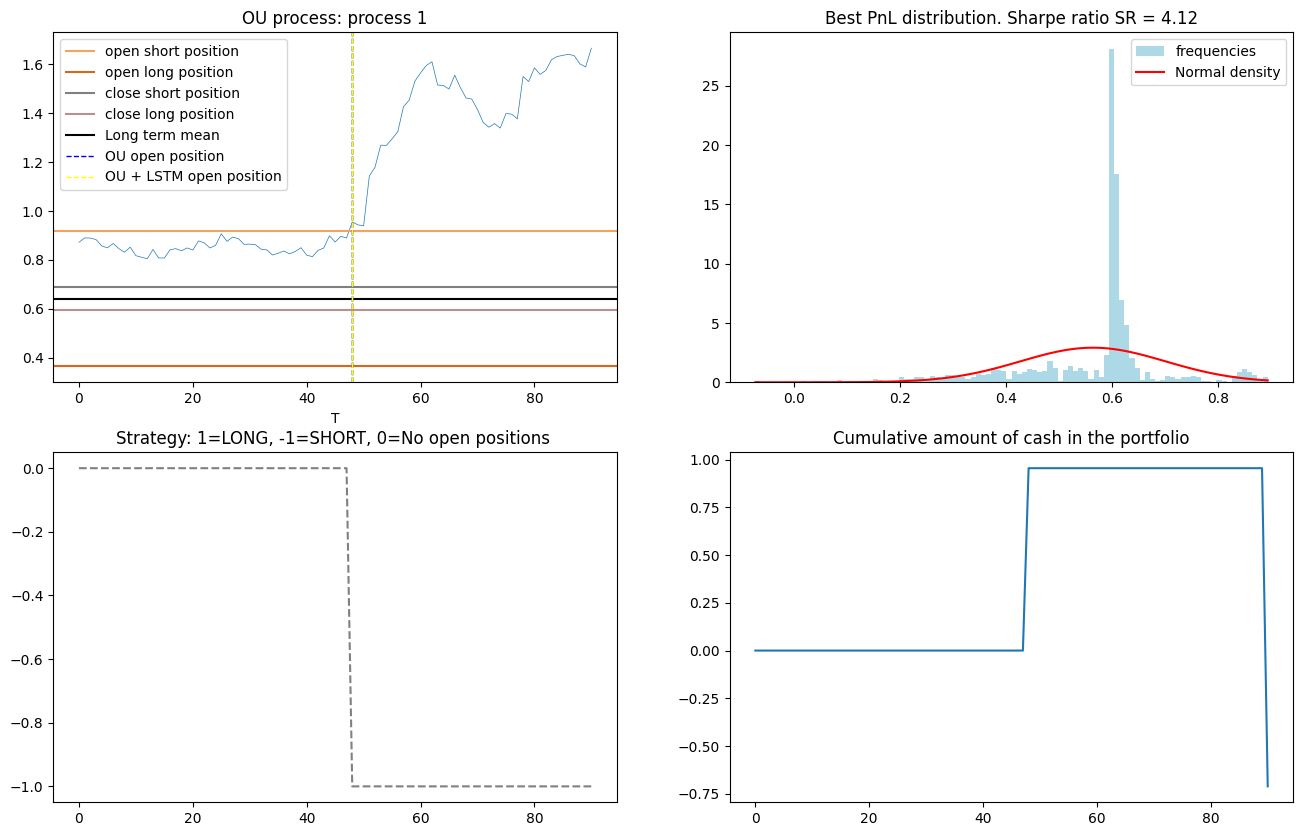

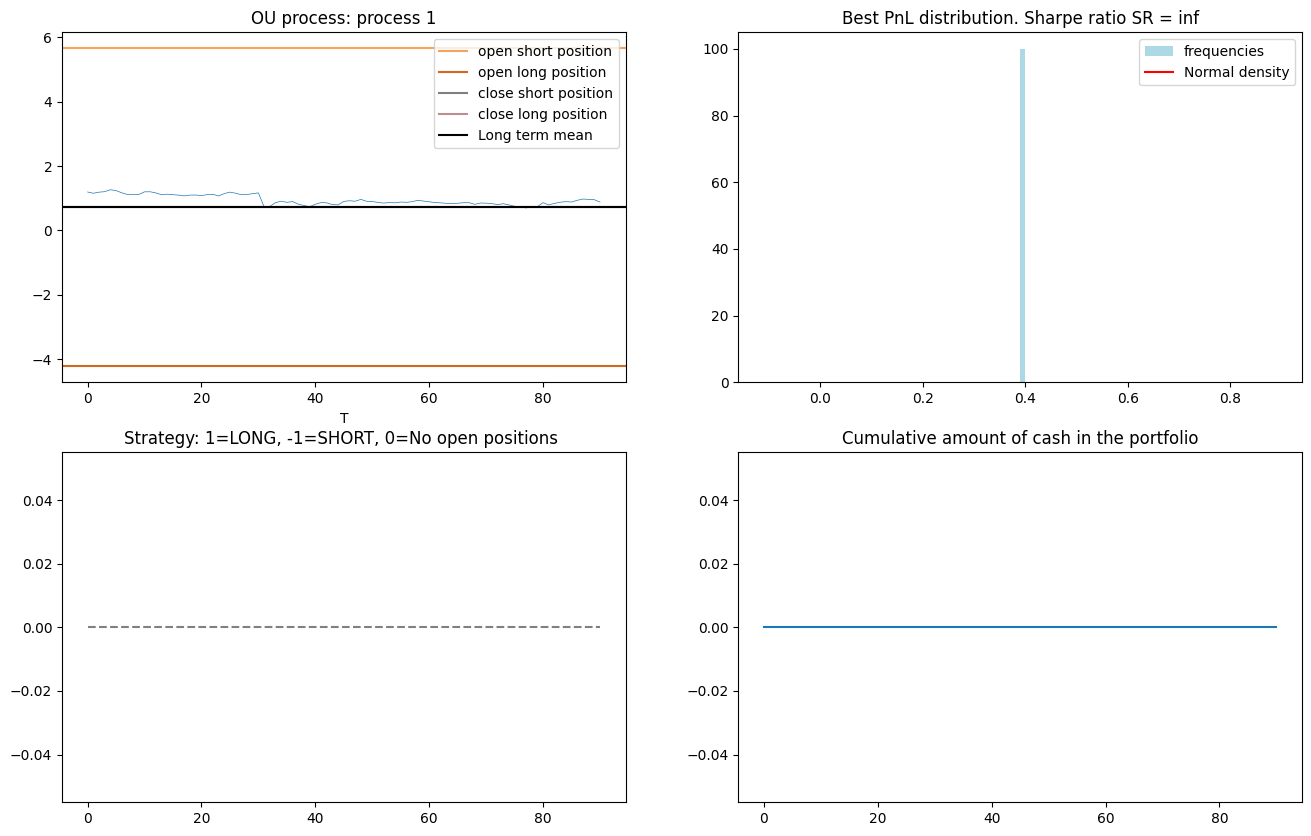

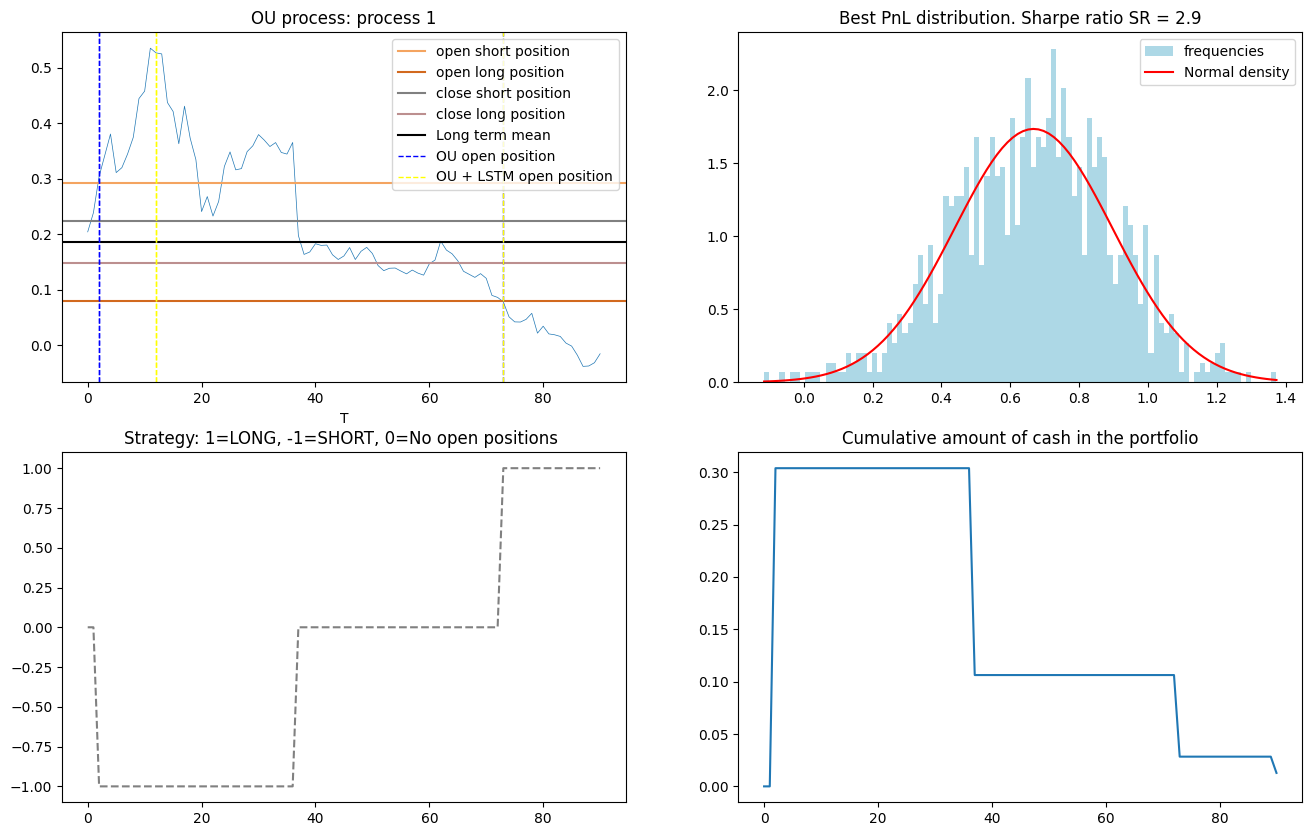

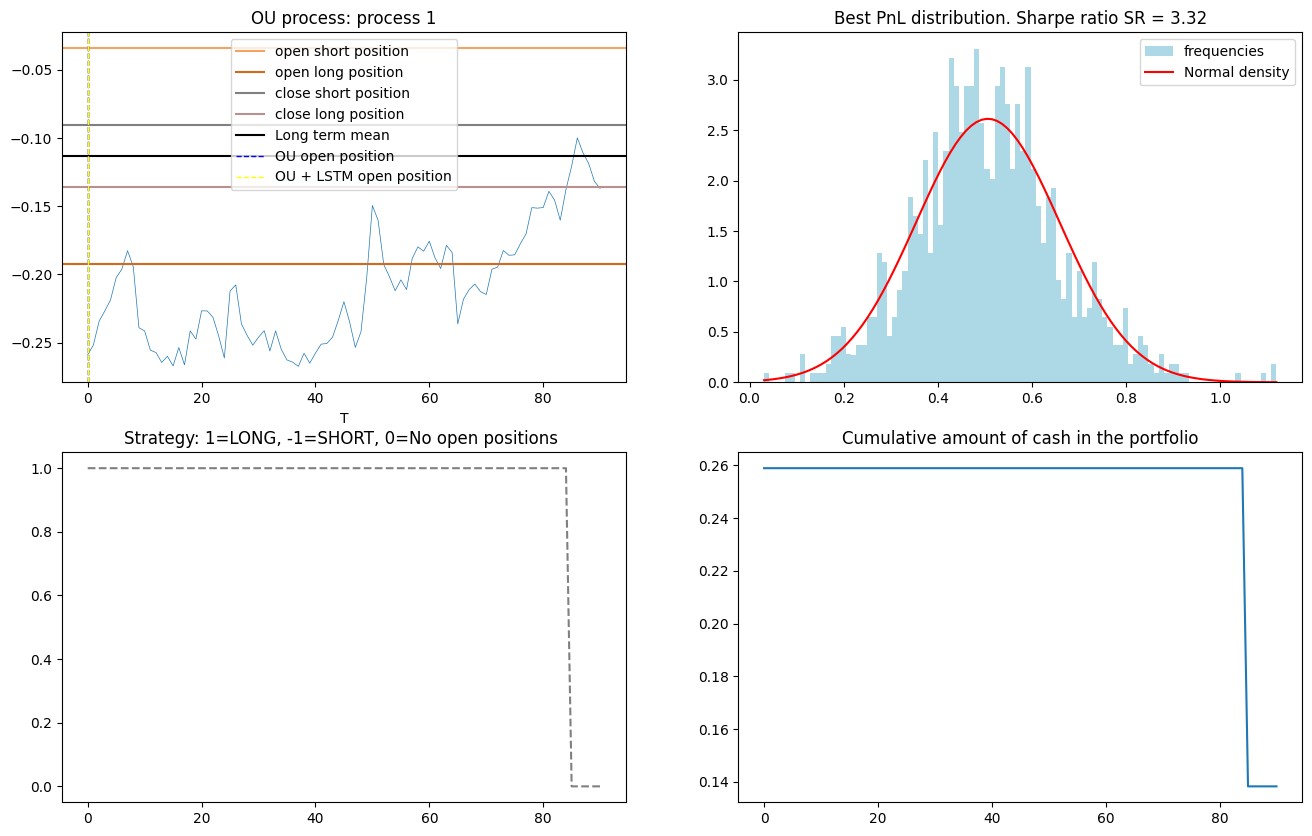

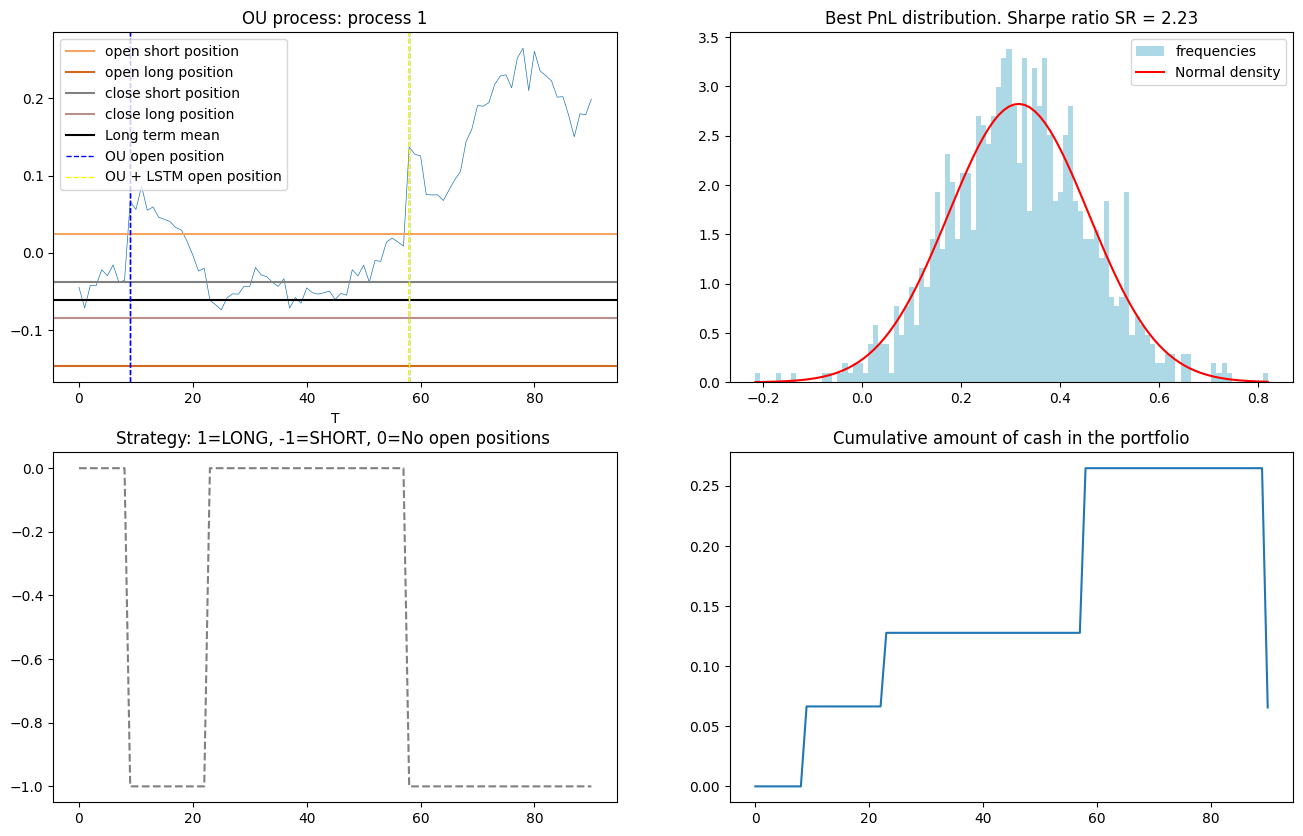

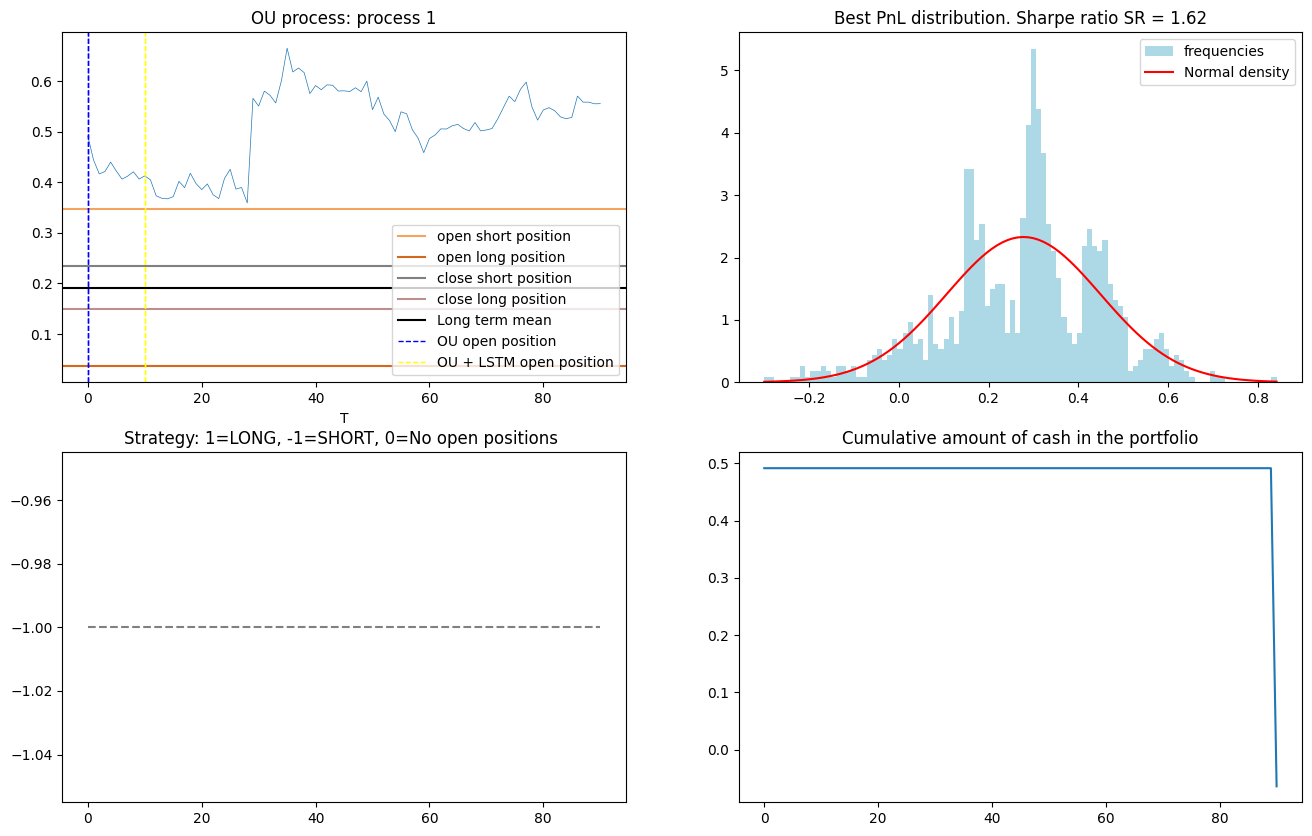

In [59]:
df = df_test

lstm_model = load_model('best_model1 (1).h5')

n_quarters_for_training = 2
n_test_quarters = np.floor((len(df)-n_quarters_for_training*91)/91)


test_start = n_quarters_for_training*91
test_end = test_start+91

train_start = test_start - n_quarters_for_training*91
train_end = test_start

max_t = 2
window_length=20
trend_max = 10

cash_OU = []
cash_vratio = []
cash_lstm = []

print('total records', len(df))

for _ in range(int(n_test_quarters)):

    cd = []
    ld = []

    # Get bollinger thresholds for training period
    print('.....Splitting Data.....')
    df_train_split = df.iloc[train_start:train_end]
    df_test_split = df.iloc[test_start:test_end]

    # Solve OU parameters
    stock_A = df_train_split['Close_C']
    stock_B = df_train_split['Close_P']
    dt = 1/len(df_train_split)
    paths = 1000  # number of paths

    # Call OU optimizer
    print('.....Solving OU Parameters.....')
    theta_star, mu_star, sigma_star, max_likelihood, results = max_B_allocation(stock_A, stock_B, dt)

    # Get Hedge Ratio
    b_alloc = np.arange(start=0.01, stop=1.01, step=0.01)
    beta_star = b_alloc[np.argmax(results[3])]

    # Create emperical OU Spreads
    emperical_OU = (df['Close_C']/df['Close_C'].iloc[0]) - beta_star * (df['Close_P']/df['Close_P'].iloc[0])
    emperical_OU_train = (df_train_split['Close_C']/df_train_split['Close_C'].iloc[0]) - beta_star * (df_train_split['Close_P']/df_train_split['Close_P'].iloc[0])
    emperical_OU_test = (df_test_split['Close_C']/df_train_split['Close_C'].iloc[0]) - beta_star * (df_test_split['Close_P']/df_train_split['Close_P'].iloc[0])

    # Retrain LSTM Model
    training_array = np.array(list(emperical_OU_train.rolling(window=20))[20:])
    training_array=training_array.reshape(-1,20,1,1)
    lstm_model.fit(training_array, np.array(emperical_OU_train.iloc[20:].shift(-1).ffill()).reshape(-1,1))


    if max_likelihood < 2.5:
        theta_star = emperical_OU_train.mean()
    else:
        theta_star = theta_star

    # Get OU Model
    print('.....Call OU Model.....')
    X, X0, std_asy, _ = OU_model(df_train_split, theta_star, mu_star, sigma_star, beta_star, dt, paths)

    # Get bollinger thresholds
    print('.....Get Optimal Bollinger Thresholds.....')
    PnL, pair, SR = optimal_bollinger_thresholds(X,X0, theta_star, std_asy, paths)

    # Get performance without vratio
    print('.....Run Trading System without VRatio.....')
    # X0_test = emperical_OU_test.iloc[0]
    X0_test = 0
    status, cash, idxs = strategy(emperical_OU_test, X0_test, mean=theta_star, std_open=pair[0], std_close=pair[1], TC=0)

    # Get vratios
    v_windows = list(emperical_OU.iloc[(test_start-max_t):].expanding(1))

    for w in range(max_t, max_t + len(df_test_split)):
        cd.append(vratio_test(v_windows[w], max_t))

    # Get performance with vratio
    print('.....Run Trading System with VRatio.....')
    # X0_test = emperical_OU_test.iloc[0]
    X0_test = 0
    status_v, cash_v, idxs_v = vratio_strategy(emperical_OU_test, X0_test, cd, mean=theta_star, std_open=pair[0], std_close=pair[1], TC=0, trend_max=trend_max)

    # Get lstm predictions
    l_windows = list(emperical_OU.iloc[(test_start-window_length):].rolling(window=20))

    for w in range(window_length, window_length + len(df_test_split)):
        ld.append(lstm_predictions(l_windows[w], lstm_model))

    # Get performance with LSTM
    print('.....Run Trading System with LSTM.....')
    # X0_test = emperical_OU_test.iloc[0]
    X0 = 0
    status_lstm, cash_l, idxs_lstm = lstm_strategy(emperical_OU_test, X0_test, ld, mean=theta_star, std_open=pair[0], std_close=pair[1], TC=0, trend_max=trend_max)

    # Save cash performance
    cash_OU.append(cash[-1])
    cash_vratio.append(cash_v[-1])
    cash_lstm.append(cash_l[-1])

    # Update Quarters
    train_start+=91
    train_end+=91
    test_start+=91
    test_end+=91

    # Plot Graphs
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(222)
    ax4 = fig.add_subplot(224)
    ax1.plot(np.arange(0,len(df_test_split)), (emperical_OU_test), linewidth=0.5)
    ax1.axhline(y = (theta_star + pair[0]), label="open short position", color="sandybrown")
    ax1.axhline(y = (theta_star - pair[0]), label="open long position", color="chocolate")
    ax1.axhline(y = (theta_star + pair[1]), label="close short position", color="gray")
    ax1.axhline(y = (theta_star - pair[1]), label="close long position", color="rosybrown")
    ax1.axhline(y = theta_star, label="Long term mean", color="black")
    [ax1.axvline(idx, linewidth=1, color='blue',linestyle="dashed",) for idx in idxs]
    if len(idxs) > 0:
        ax1.axvline(idxs[0], linewidth=1, color ='blue', linestyle="dashed", label="OU open position")
    # [ax1.axvline(idx_v, linewidth=1, color='green', linestyle="dashed",) for idx_v in idxs_v]
    # if len(idxs_v) > 0:
    #     ax1.axvline(idxs_v[0], linewidth=1,color ='green', linestyle="dashed", label="OU + V-Ratio open position")
    [ax1.axvline(idx_lstm, linewidth=1, color='yellow', linestyle="dashed") for idx_lstm in idxs_lstm]
    if len(idxs_lstm) > 0:
        ax1.axvline(idxs_lstm[0], linewidth=1,color ='yellow', linestyle="dashed", label="OU + LSTM open position")

    ax1.legend()
    ax1.set_title(f"OU process: process {1}")
    ax1.set_xlabel("T")

    ax2.plot(np.arange(0,len(df_test_split),1), status, linestyle="dashed", color="grey")
    ax2.set_title("Strategy: 1=LONG, -1=SHORT, 0=No open positions ")

    ax3.hist(PnL, density=True, bins=100, facecolor="LightBlue", label="frequencies")
    x = np.linspace(PnL.min(), PnL.max(), 100)
    ax3.plot(x, ss.norm.pdf(x, loc=PnL.mean(), scale=PnL.std()), color="r", label="Normal density")
    SR = PnL.mean() / PnL.std()
    ax3.legend()
    ax3.set_title(f"Best PnL distribution. Sharpe ratio SR = {SR.round(2)}")

    ax4.plot(np.arange(0,len(df_test_split),1), cash)
    ax4.set_title("Cumulative amount of cash in the portfolio")
    

# show all plots
plt.show()


In [64]:
np.sum(cash_OU)

-0.8647063350159254

Text(0.5, 1.0, 'OU Model: Quarterly Cash Accrued')

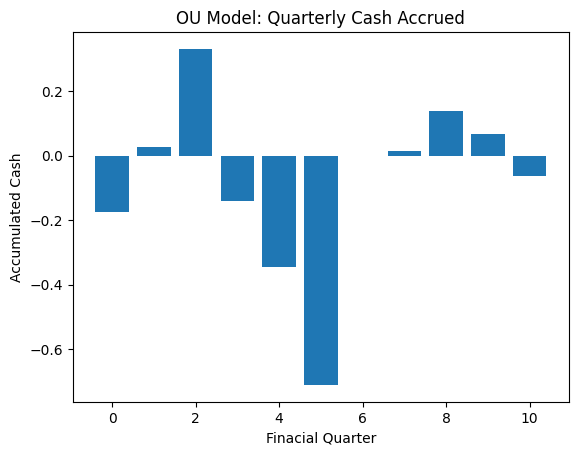

In [76]:
plt.bar(np.arange(0,len(cash_OU)),cash_OU)
plt.xlabel('Finacial Quarter')
plt.ylabel('Accumulated Cash')
plt.title('OU Model: Quarterly Cash Accrued')

Text(0.5, 1.0, 'OU Model: Cash Histogram')

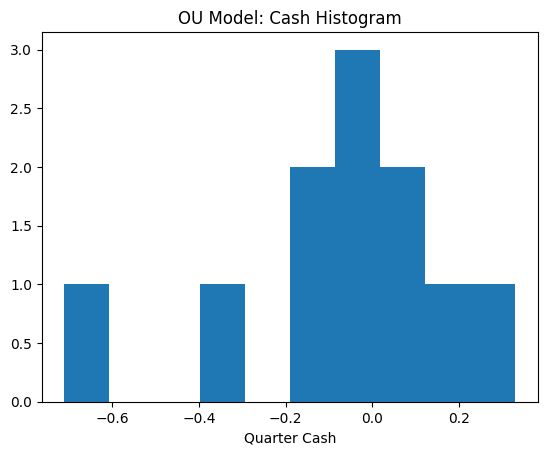

In [83]:
plt.hist(cash_OU)
plt.xlabel('Quarter Cash')
# plt.ylabel('Accumulated Cash')
plt.title('OU Model: Cash Histogram')

In [85]:
np.sum(cash_vratio)

-0.6427334647741153

Text(0.5, 1.0, 'OU Model + V-Ratio: Quarterly Cash Accrued')

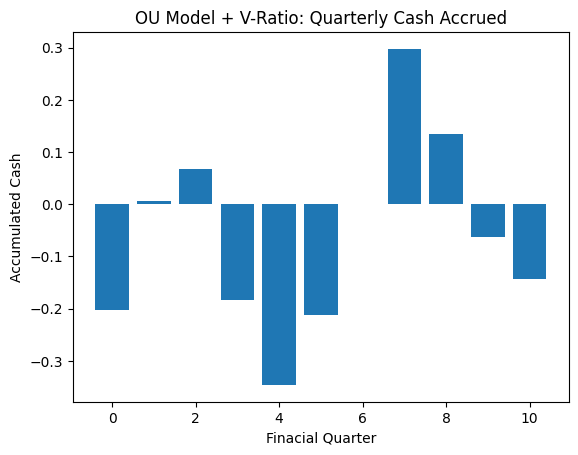

In [77]:
plt.bar(np.arange(0,len(cash_vratio)),cash_vratio)
plt.xlabel('Finacial Quarter')
plt.ylabel('Accumulated Cash')
plt.title('OU Model + V-Ratio: Quarterly Cash Accrued')

Text(0.5, 1.0, 'OU Model + V-Ratio: Cash Histogram')

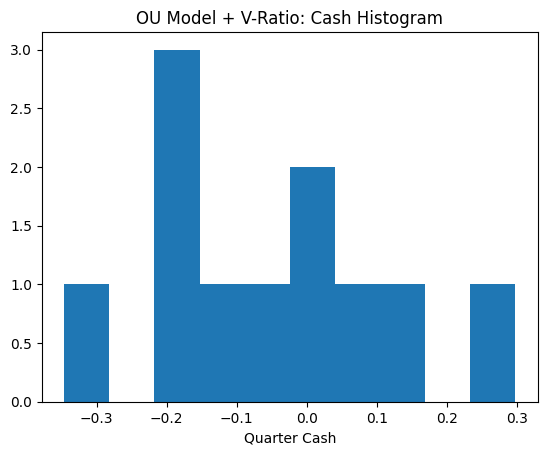

In [84]:
plt.hist(cash_vratio)
plt.xlabel('Quarter Cash')
# plt.ylabel('Accumulated Cash')
plt.title('OU Model + V-Ratio: Cash Histogram')

In [62]:
np.sum(cash_lstm)

-1.1185233353483397

Text(0.5, 1.0, 'OU Model + LSTM: Quarterly Cash Accrued')

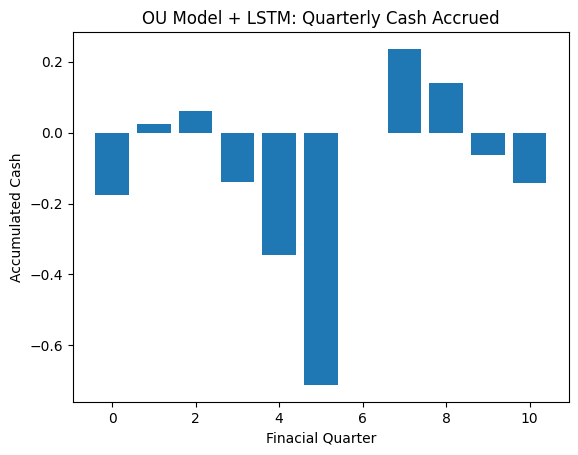

In [86]:
plt.bar(np.arange(0,len(cash_lstm)),cash_lstm)
plt.xlabel('Finacial Quarter')
plt.ylabel('Accumulated Cash')
plt.title('OU Model + LSTM: Quarterly Cash Accrued')

Text(0.5, 1.0, 'OU Model + LSTM: Cash Histogram')

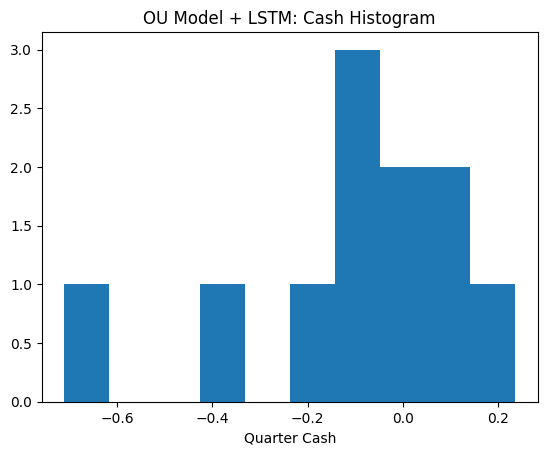

In [87]:
plt.hist(cash_lstm)
plt.xlabel('Quarter Cash')
# plt.ylabel('Accumulated Cash')
plt.title('OU Model + LSTM: Cash Histogram')